# 第六週: 中文文集的情緒分析2

**Author:** 劉岱宜<br>
**Date created:** 2021/09/21<br>
**Last modified:** 2020/09/21<br>
+ 資料來源:
    + twitter api 爬取貼文
    + 關鍵字:「哈利波特」、「 魔法覺醒」(637筆)
    + 時間: 2021-09-01 ~ 2021-09-20
+ 分析方式
    + POS、NER: CKIP 中研院字詞分析套件
    + 情緒分析: SnowNLP
+ 分析流程
    + 1. CKIP 介紹
    + 2. 文章抓取 & CKIP 標註¶
        + 1. 抓取twitter貼文
        + 2. CKIP 斷詞擷取POS、NER
    + 3. 開始分析
        + 1. NER、POS相關分析
        + 2. SnowNLP分析情緒，劃出日期情緒趨勢與相關字詞

In [1]:
# ckip
from ckiptagger import data_utils, construct_dictionary, WS, POS, NER # pip install ckiptagger
import configparser, re, os, io

from wordcloud import WordCloud, ImageColorGenerator

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from datetime import datetime, timedelta

## 1. CKIP 介紹

### CKIP 套件 
+ 是中研院研發的專門處理繁體字的套件，效果比coreNLP好一些
+ github: https://github.com/ckiplab/ckiptagger

In [2]:
# 安裝ckip套件
# pip install -U ckiptagger[tfgpu,gdown]

In [3]:
# data_utils.download_data_gdown("./") # gdrive-ckip # 下載ckip model

In [4]:
# To use CPU:
ws = WS("./data")
pos = POS("./data")
ner = NER("./data")

/usr/local/anaconda3/envs/test/lib/python3.6/site-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:901: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  warnings.warn("`tf.nn.rnn_cell.LSTMCell` is deprecated and will be "
/usr/local/anaconda3/envs/test/lib/python3.6/site-packages/keras/engine/base_layer_v1.py:1684: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


### CKIP 標註範例

+ CKIP 標註任務
    + 斷詞（ws）
        + 可以設定自己的辭典
            + `recommend_dictionary` 推薦字典
            + `coerce_dictionary` 強制字典
    + 實體辨識（ner）
    + 詞性標註（pos）
        + 名詞對應: https://ckip.iis.sinica.edu.tw/service/corenlp/

In [5]:
word_to_weight = {
    "魔法覺醒": 1,
    "睽違已久": 2,
}
dictionary1 = construct_dictionary(word_to_weight)
print(dictionary1)

[(4, {'魔法覺醒': 1.0, '睽違已久': 2.0})]


In [6]:
sentence_list = [
    "哈利波特魔法覺醒是一個中國網易代理的粉絲睽違已久的手遊app",
     "很多人滿心期待這款英國出品的遊戲，卻又害怕受傷害"
]

word_sentence_list = ws(sentence_list, coerce_dictionary = dictionary1)  # 斷詞
pos_sentence_list = pos(word_sentence_list)
entity_sentence_list = ner(word_sentence_list, pos_sentence_list)

def print_word_pos_sentence(word_sentence, pos_sentence):
    assert len(word_sentence) == len(pos_sentence)
    for word, pos in zip(word_sentence, pos_sentence):
        print(f"{word}({pos})", end="\u3000")
    print()
    return
    
for i, sentence in enumerate(sentence_list):
    print()
    print(f"sentence {i}: {sentence}")
    print("\nPOS: ", end="\u3000")
    print_word_pos_sentence(word_sentence_list[i],  pos_sentence_list[i])
    print("\nNER: ")
    for entity in sorted(entity_sentence_list[i]):
        print(entity)


sentence 0: 哈利波特魔法覺醒是一個中國網易代理的粉絲睽違已久的手遊app

POS: 　哈利波特(Nb)　魔法覺醒(Nb)　是(SHI)　一(Neu)　個(Nf)　中國(Nc)　網易(Nb)　代理(VC)　的(DE)　粉絲(Na)　睽違已久(VH)　的(DE)　手遊(Na)　app(FW)　

NER: 
(11, 13, 'NORP', '中國')
(13, 15, 'ORG', '網易')

sentence 1: 很多人滿心期待這款英國出品的遊戲，卻又害怕受傷害

POS: 　很多(Neqa)　人(Na)　滿心(D)　期待(VK)　這(Nep)　款(Nf)　英國(Nc)　出品(VC)　的(DE)　遊戲(Na)　，(COMMACATEGORY)　卻(D)　又(D)　害怕(VK)　受(VJ)　傷害(Na)　

NER: 
(9, 11, 'GPE', '英國')


## 2. 文章抓取 & CKIP 標註

### Step 1：用twitter抓資料
+ 首先申請twitter 相關的 key secret
+ https://developer.twitter.com/en/docs/tutorials/step-by-step-guide-to-making-your-first-request-to-the-twitter-api-v2
+ 申請完之後token會在 `Developer Portal > project & Apps > Keys and tokens`

In [19]:
import tweepy as tw
# API Key and Secret
CONSUMER_KEY = 'eNMQchTiHN7WjnQksfvHAJgA9'
CONSUMER_SECRET = 'MS5xRYuRUERepYaSeABsNjREf9Fvthr7ihsrtswYqBm51GTvPB'
# Access Token and Secret
OAUTH_TOKEN = '1193849843279511552-dXvAjOpZjXFI5BTDLZBW5Ljq551OG1'
OAUTH_TOKEN_SECRET = 'wWGtd0HmThSgHh5Gdi1VDrVRATm1sHJpMi3gcFBC1qxGT'

In [20]:
# 開通api權限
auth = tw.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(OAUTH_TOKEN, OAUTH_TOKEN_SECRET)
api = tw.API(auth, wait_on_rate_limit=True)

In [21]:
# 將抓到的貼文轉為datafranme
def twitter_table(keyword, from_date,end_date, lang_type,limit):
    
    # 定義 search api 參數
    all_tweets = tw.Cursor(
                        api.search,
                        q=keyword,
                        lang=lang_type,
                        since=from_date,
                        until=end_date
                    ).items(limit)    
    
    # 定義tweet attribute
    tweets_list= [[tweet.created_at, tweet.id, tweet.user.screen_name,
               tweet.user.name, tweet.text, tweet.favorite_count, tweet.retweet_count,tweet.source
              ] for tweet in all_tweets]
    
    # 定義欄位名稱
    tweet_table = pd.DataFrame(data=tweets_list, 
                        columns=['created_at','status_id', 'user_id',
                                 'user_name', 'text','favourites', 'retweet','source'])
        
    tweet_table = tweet_table[['created_at','status_id', 'user_id',
                               'user_name', 'text','favourites', 'retweet','source']]
    
    return tweet_table

+ 設定爬文抓取條件
    + 時間為 2021-09-01 ~ 2021-09-20 （2021-09-09 遊戲發布）
    + 關鍵字為 「哈利波特」 或 「魔法覺醒」，去掉重複推文的文章
    + 更多 query 規則: https://developer.twitter.com/en/docs/twitter-api/tweets/search/integrate/build-a-query
    + lang 可以抓取的語言列表: https://developer.twitter.com/en/docs/twitter-for-websites/supported-languages

In [22]:
# 抓到 330 筆資料
keyword = "哈利波特 OR 魔法覺醒 -filter:retweets"
from_date = "2021-09-01"  
end_date = "2021-09-20"  
lang_type = "zh-cn" 
limit = 2000

In [23]:
tweets_df = twitter_table(keyword, from_date,end_date, lang_type,limit)
tweets_df

,created_at,status_id,user_id,user_name,text,favourites,retweet,source
0,2021-09-19 23:50:28,1439738694584311810,buns_chen,BunsChen,@ruruisme_ 哈利波特，雙人組隊啊😂,0,0,Twitter for iPhone
1,2021-09-19 23:48:16,1439738139346567170,jeonchil,I'm顧西,我跟我媽說湯姆跟艾瑪以前在哈利波特片場互相喜歡⋯\n：欸你知道馬份跟妙麗戲外暗戀對方嗎\n\...,5,0,Twitter for Android
2,2021-09-19 23:47:09,1439737860584660998,James_is_back_,阿展,真的有哈利波特迷喜歡那個手遊嗎?\n我如果看到喜歡的作品被改成支味十足的手遊還搞言論審查真的...,2,0,Twitter for Android
3,2021-09-19 23:32:12,1439734099329966083,sujung9304,🐋수정✨,放假想要做的事\n- 迪士尼💕\n- 哈利波特\n- 整理自己的想法\n- 休息\n- 看書,1,0,Twitter for iPhone
4,2021-09-19 22:58:31,1439725619840004104,OvO_Miao,憨批猫妖🏳️‍🌈,慌了一个周末 把实验的的candidate compounds定下来了 老婆还没起床～ 想脑...,2,0,Twitter for iPhone
...,...,...,...,...,...,...,...,...
631,2021-09-13 10:55:17,1437369285010083854,NhaP8v,023-感官先生,哈利波特 玩一天脑壳都是懵的,3,0,Twitter for iPhone
632,2021-09-13 10:53:18,1437368786017939461,MoDuckD,冬錢臘鴨-MoDuck@欲速則不達,事實上，HP根本不適合改編手游。\nFans主要是想在遊戲中體驗哈利波特的魔法世界觀，所以先...,20,0,Twitter Web App
633,2021-09-13 10:15:08,1437359183578365963,lngxing14,língxiāng‎🐾🐳,哈利波特真帅,1,0,Twitter for iPhone
634,2021-09-13 10:12:59,1437358639631659011,freshwithblood,killemall,ipad：哈利波特\n手機：推特\n電腦：zoom class lol,0,0,Twitter for iPhone


In [24]:
# 將推特文章存成csv
# tweets_df.to_csv(r'source/zh/tweets_HarryPotter_zhcn.csv', index = False)

In [79]:
# 讀取已經抓取完成的推文
tweets_df = pd.read_csv("source/zh/tweets_HarryPotter_zhcn.csv")

### Step 2：將抓取結果用 CKIP 擷取 POS 和 NER

(1) 定義文字清理的相關function

In [25]:
def Segmentation_Core(data, tokenizer):
    # 將所有的斷行字元配上 escape 以防失效
    regexPattern = '|'.join(map(re.escape, tokenizer))
    output_list = re.split(regexPattern, data)
    # 過濾空白行
    output_list = list(filter(None, output_list))
    return output_list

def Sentence_Segmentation(article, keep_digits=False, keep_alphabets=False):
    """ Sentence_Segmentation function 用於執行中文斷行任務

    順序如下：
    1. 去除(\\n)
    2. 去除特殊符號字元
    3. 保留數字
    4. 依照斷句字元進行斷句全形的分號、逗號、句號、問號以及驚嘆號
    5. 避免空白斷句結果

    Args:
        article(string): 欲斷行之文章內容
        keep_digits(Boolean): 決定是否保留數字於斷行後的結果
        keep_alphabets(Boolean): 決定是否保留字母於斷行後的結果
    Returns:
        List [] 每個 element 就是一行
    """
    final_res = []
    sepical_symbols = r'[.＂<>:《》+\-=#$%&()*@＃＄％＆＇\(\)\[\]\{\}（）＊＋－／：\
    ＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､、〃》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〾〿–—‘’‛“”„‟…‧﹏★→─]+'
    segmentation_used_note = (";", "；", "！", "!", "？", "?", "。")
    
#     paragraphs = list(filter(None, article.split("\n")))
    paragraphs = list(filter(lambda x: re.sub(r'\s+','', x), article.split("\n")))
#     print(len(paragraphs))
#     print(paragraphs)
    result = []
    for paragraph in paragraphs:

        clean_paragraph = paragraph
        try:
            if not keep_digits:
                clean_paragraph = re.sub(r'\d*\.?\d+','', clean_paragraph) #remove space & digits
            if not keep_alphabets:
                clean_paragraph = re.sub('[a-zA-Z]+', '', clean_paragraph)
            
            clean_paragraph = re.sub(r'[\s]+','', clean_paragraph) #remove space
            
            clean_paragraph = re.sub(sepical_symbols,'',clean_paragraph)
            
        except:
            _logger.info("error")
            return "error"
        
        res = Segmentation_Core(clean_paragraph, segmentation_used_note)
        result.append(res)
    
    return result

(2) CKIP 設定
+ 讀入自定義的哈利波特辭典
    + 到搜狗字典下載需要的檔案，通常會是 `.scel` 檔
    + 把 `.scel` 轉 `.txt`:https://www.toolnb.com/tools-lang-zh-TW/scelto.html
    + 簡體轉繁體: https://txtconv.arpuli.com/

In [26]:
# 自定義辭典
with open('dict/harry.txt') as f:
    lines = f.read().splitlines()

dict_harry = {k: 1 for v, k in enumerate(lines)}
dictionary2 = construct_dictionary(dict_harry)
print(dictionary2)

[(2, {'西追': 1.0, '阿瑟': 1.0, '艾博': 1.0, '傲羅': 1.0, '巴蒂': 1.0, '白鮮': 1.0, '斑斑': 1.0, '貝恩': 1.0, '貝爾': 1.0, '彼得': 1.0, '比爾': 1.0, '波爾': 1.0, '伯莎': 1.0, '波特': 1.0, '布朗': 1.0, '草藥': 1.0, '查理': 1.0, '長袍': 1.0, '達力': 1.0, '德瑞': 1.0, '迪安': 1.0, '地精': 1.0, '洞聽': 1.0, '斗篷': 1.0, '多比': 1.0, '厄尼': 1.0, '飛馬': 1.0, '飛行': 1.0, '糞石': 1.0, '分體': 1.0, '鳳凰': 1.0, '福吉': 1.0, '弗農': 1.0, '芙蓉': 1.0, '附身': 1.0, '坩堝': 1.0, '高爾': 1.0, '光輪': 1.0, '哈利': 1.0, '哈珀': 1.0, '海格': 1.0, '漢娜': 1.0, '赫敏': 1.0, '黑湖': 1.0, '魂器': 1.0, '級長': 1.0, '加隆': 1.0, '禁林': 1.0, '金妮': 1.0, '巨怪': 1.0, '巨人': 1.0, '凱蒂': 1.0, '科林': 1.0, '苦艾': 1.0, '窺鏡': 1.0, '拉環': 1.0, '狼人': 1.0, '勒梅': 1.0, '莉莉': 1.0, '麗塔': 1.0, '琳妮': 1.0, '陋居': 1.0, '魯伯': 1.0, '盧多': 1.0, '盧娜': 1.0, '盧平': 1.0, '路威': 1.0, '羅恩': 1.0, '羅傑': 1.0, '羅琳': 1.0, '羅南': 1.0, '麻瓜': 1.0, '馬人': 1.0, '麥格': 1.0, '媚娃': 1.0, '密室': 1.0, '莫恩': 1.0, '莫麗': 1.0, '魔藥': 1.0, '魔杖': 1.0, '魔咒': 1.0, '穆迪': 1.0, '牡鹿': 1.0, '納特': 1.0, '納威': 1.0, '納維': 1.0, '尼可': 1.0, '諾伯': 1.0, '諾特': 1.0, '潘西': 1.0, '佩妮'

In [28]:
def get_pos(post_id, word_sentence, pos_sentence):
    tokens = []
    print("\nPOS: ", end="\u3000")
    assert len(word_sentence) == len(pos_sentence)
    for word, pos in zip(word_sentence, pos_sentence): # token level
        tokens.append([post_id,word,pos]) 
        print(f"{word}({pos})", end="\u3000")
    return tokens

def get_ner(post_id, entity_sentence):
    entities = []
    print("\nNER:___________ ")
    for entity in sorted(entity_sentence): # token level
        entities.append([post_id, entity[3],entity[2]]) 
    return entities

def get_nlp_result(data_df):
    start = time.time()

    pos_list = []
    entity_list = []
    sentence_list = []
    
    for index, row in data_df.iterrows(): # document level    
        print(f"\ndocument {index}") 

        # clean data
        result = [] 
        tmp = Sentence_Segmentation(row['text']) 
        flat_list = [item for sublist in tmp for item in sublist]

        # ckip
        word_sentence_list = ws(flat_list, coerce_dictionary = dictionary2) # set dictionary 
        pos_sentence_list = pos(word_sentence_list)
        entity_sentence_list = ner(word_sentence_list, pos_sentence_list)

        for i, sentence in enumerate(flat_list): # sentence level
            print(f"sentence {i}: {sentence}")
            sentence_list.append([row['status_id'],sentence])            
            temp_tokens = get_pos(row['status_id'],word_sentence_list[i],  pos_sentence_list[i])
            temp_entites = get_ner(row['status_id'],entity_sentence_list[i])

            pos_list.append(temp_tokens)
            if len(temp_entites) != 0:
                entity_list.append(temp_entites)
            
    pos_flat = [item for sublist in pos_list for item in sublist]
    entity_flat = [item for sublist in entity_list for item in sublist]

    pos_table = pd.DataFrame(data=pos_flat, 
                    columns=['status_id','word','pos'])        
    
    entity_table = pd.DataFrame(data=entity_flat, 
                        columns=['status_id','word','ner']) 

    sentence_table = pd.DataFrame(data=sentence_list, 
                    columns=['status_id','sentence']) 

    end = time.time()
    print("time costing: {}".format(end - start))

    return pos_table, entity_table, sentence_table

In [31]:

# pos_table, entity_table, sentence_table = get_nlp_result(tweets_df)
# time costing: 43.8019802570343


document 0
sentence 0: _哈利波特，雙人組隊啊😂

POS: 　_(FW)　哈利波特(Nb)　，(COMMACATEGORY)　雙人(Na)　組隊(VA)　啊(T)　😂(Na)　
NER:___________ 

document 1
sentence 0: 我跟我媽說湯姆跟艾瑪以前在哈利波特片場互相喜歡⋯

POS: 　我(Nh)　跟(P)　我(Nh)　媽(Na)　說(VE)　湯姆(Nb)　跟(P)　艾瑪(Nb)　以前(Nd)　在(P)　哈利波特(Nb)　片場(Nc)　互相(D)　喜歡(VK)　⋯(T)　
NER:___________ 
sentence 1: 欸你知道馬份跟妙麗戲外暗戀對方嗎

POS: 　欸(I)　你(Nh)　知道(VK)　馬份(Nb)　跟(P)　妙麗(Nb)　戲(Na)　外(Ng)　暗戀(VJ)　對方(Nh)　嗎(T)　
NER:___________ 
sentence 2: 👩‍👧真的假的我不知道欸

POS: 　👩‍👧(Na)　真的(D)　假(VH)　的(DE)　我(Nh)　不(D)　知道(VK)　欸(I)　
NER:___________ 
sentence 3: 可是他們沒有在一起

POS: 　可是(Cbb)　他們(Nh)　沒有(D)　在一起(VH)　
NER:___________ 
sentence 4: 乾他們一起拍戲年年欸

POS: 　乾(VH)　他們(Nh)　一起(D)　拍戲(VA)　年年(D)　欸(I)　
NER:___________ 
sentence 5: 艾瑪就說湯姆不可能不知道她喜歡他⋯

POS: 　艾瑪(Nb)　就(D)　說(VE)　湯姆(Nb)　不可能(D)　不(D)　知道(VK)　她(Nh)　喜歡(VK)　他(Nh)　⋯(T)　
NER:___________ 
sentence 6: 我超氣，他們沒在一起欸我超氣

POS: 　我(Nh)　超氣(VH)　，(COMMACATEGORY)　他們(Nh)　沒(D)　在一起(VH)　欸(I)　我(Nh)　超氣(VH)　
NER:___________ 
sentence 7: 👩‍👧你氣三小

POS: 　👩‍👧(Na)　你(Nh)　氣(VK)　三(Neu)　小(VH)　
NER:___________ 

document 

sentence 0: 原本想烤肉不是物理香噴噴的那個烤肉

POS: 　原本(D)　想(VE)　烤(VC)　肉(Na)　不(D)　是(SHI)　物理(Na)　香噴噴(VH)　的(DE)　那(Nep)　個(Nf)　烤(VC)　肉(Na)　
NER:___________ 
sentence 1: 結果翻到一半就開始打瞌睡

POS: 　結果(Dk)　翻到(VC)　一半(Neqa)　就(D)　開始(VL)　打瞌睡(VA)　
NER:___________ 
sentence 2: 所以我決定玩哈利波特去

POS: 　所以(Cbb)　我(Nh)　決定(VE)　玩(VC)　哈利波特(Nb)　去(D)　
NER:___________ 

document 30
sentence 0: 对约翰威廉姆斯我是彻底服气的今天可以通撸一遍哈利波特🪄

POS: 　对约翰威廉姆斯(Nb)　我(Nh)　是(SHI)　彻底(Na)　服气(VH)　的(DE)　今天(Nd)　可以(D)　通撸(VC)　一(Neu)　遍(Nf)　哈利波特(Nb)　🪄(FW)　
NER:___________ 
sentence 1: 哈利波特组曲重返魔法世界

POS: 　哈利波特(Nb)　组曲(Na)　重返(VCL)　魔法(Na)　世界(Nc)　
NER:___________ 
sentence 2: ///来自

POS: 　///来(FW)　自(Nh)　
NER:___________ 

document 31
sentence 0: /

POS: 　/(FW)　
NER:___________ 
sentence 1: 今天發現🐧原來有載哈利波特喔好激動

POS: 　今天(Nd)　發現(VE)　🐧(FW)　原來(D)　有(V_2)　載(VC)　哈利波特(Nb)　喔(T)　好(Dfa)　激動(VH)　
NER:___________ 
sentence 2: 就莫名悸動

POS: 　就(D)　莫名(VH)　悸動(VA)　
NER:___________ 
sentence 3: 就莫名悸動

POS: 　就(D)　莫名(VH)　悸動(VA)　
NER:___________ 
sentence 4: 也許是昨天跟姊談完好多關於🐧的事今天我也有點暈^^

POS: 　也許(D)　是(SHI)　昨

sentence 0: 今天還沒解哈利波特魔法覺醒的任務

POS: 　今天(Nd)　還(D)　沒(D)　解(VC)　哈利波特(Nb)　魔法覺醒(VH)　的(DE)　任務(Na)　
NER:___________ 
sentence 1: 有遇到很讚可以一起解任務的好朋朋

POS: 　有(V_2)　遇到(VC)　很(Dfa)　讚(VH)　可以(D)　一起(D)　解(VC)　任務(Na)　的(DE)　好朋朋(Na)　
NER:___________ 
sentence 2: 他們人好好😭

POS: 　他們(Nh)　人(Na)　好好(VH)　😭(FW)　
NER:___________ 

document 59
sentence 0: 我可以開一個玩哈利波特耍笨日記了

POS: 　我(Nh)　可以(D)　開(VC)　一(Neu)　個(Nf)　玩(VC)　哈利波特(Nb)　耍笨(Na)　日記(Na)　了(T)　
NER:___________ 

document 60
sentence 0: 今天喝到了很好喝的牛奶草莓奶綠燒仙草

POS: 　今天(Nd)　喝到(VC)　了(Di)　很(Dfa)　好喝(VH)　的(DE)　牛奶(Na)　草莓(Na)　奶(Na)　綠燒(VC)　仙草(Na)　
NER:___________ 
sentence 1: 因為連續下雨，整個人都昏昏欲睡

POS: 　因為(Cbb)　連續(D)　下雨(VA)　，(COMMACATEGORY)　整(Neqa)　個(Nf)　人(Na)　都(D)　昏昏欲睡(VH)　
NER:___________ 
sentence 2: 玩了一天哈利波特的手遊

POS: 　玩(VC)　了(Di)　一(Neu)　天(Nf)　哈利波特(Nb)　的(DE)　手(Na)　遊(VCL)　
NER:___________ 
sentence 3: 今天通關了很多

POS: 　今天(Nd)　通關(VA)　了(Di)　很多(Neqa)　
NER:___________ 
sentence 4: 單人決鬥的時候連續幾次都在殘血的狀態下把對方給反殺了，很開心

POS: 　單人(Na)　決鬥(VA)　的(DE)　時候(Na)　連續(D)　幾(Neu)　次(Nf)　都(D)　在(P)　殘血(Na)　的(DE)　狀態(Na)　

sentence 0: 于小宇这🥣回天津了偌大的房间就我一个人又爽又无聊

POS: 　于小宇(Nb)　这🥣(FW)　回(VCL)　天津(Nc)　了(Di)　偌大(A)　的(DE)　房间(Na)　就(D)　我(Nh)　一(Neu)　个(FW)　人(Na)　又(Caa)　爽(VH)　又(Caa)　无(VH)　聊(VE)　
NER:___________ 
sentence 1: 我最近下载了那个哈利波特的游戏还不错挺好玩我选的蛇院不过是萌新也就这两天刚下载最高连胜才没几场😿

POS: 　我(Nh)　最近(Nd)　下载(VC)　了(Di)　那(Nep)　个(FW)　哈利波特(Nb)　的(DE)　游戏还(Nb)　不(D)　错(VH)　挺(Dfa)　好玩(VH)　我(Nh)　选(FW)　的(DE)　蛇院(Nc)　不过(VH)　是(SHI)　萌新(Nb)　也(D)　就(D)　这两(VH)　天刚(Na)　下载(VA)　最(Dfa)　高(VH)　连胜(Na)　才(Da)　没几场😿(Na)　
NER:___________ 
sentence 2: 是放学路上看着这个☁️很像小怪兽就拍下来啦剩下的风景照就都

POS: 　是(SHI)　放(VC)　学(FW)　路(Na)　上(Ncd)　看(VC)　着这个☁(Na)　️(Na)　很(Dfa)　像(VG)　小(VH)　怪兽(Na)　就(D)　拍下来(VC)　啦(T)　剩下(VJ)　的(DE)　风景照(Na)　就(D)　都(D)　
NER:___________ 

document 92
sentence 0: 跟朋朋看哈利波特第一集

POS: 　跟(P)　朋朋(Nb)　看(VC)　哈利波特(Nb)　第一(Neu)　集(Nf)　
NER:___________ 
sentence 1: 我都在吐嘈

POS: 　我(Nh)　都(D)　在(P)　吐嘈(VA)　
NER:___________ 
sentence 2: 古靈閣是僅次於霍格華茲安全的地方

POS: 　古靈閣(Nc)　是(SHI)　僅次於(VJ)　霍格華茲(Nb)　安全(VH)　的(DE)　地方(Na)　
NER:___________ 
sentence 3: 古靈閣遭竊

POS: 　古靈閣(Nc)　遭(P)　竊(VD)　
NER:___________ 
sente

sentence 0: 還不錯，因為是魔法世界所有玩法很多樣，有攻略森林，還有玩家巫師對戰，學院舞會節奏遊戲，跟問答跟哈利波特系列的內容，占卜學等等

POS: 　還(D)　不錯(VH)　，(COMMACATEGORY)　因為(Cbb)　是(SHI)　魔法(Na)　世界(Nc)　所有(Neqa)　玩法(Na)　很(Dfa)　多樣(VH)　，(COMMACATEGORY)　有(V_2)　攻略(VC)　森林(Na)　，(COMMACATEGORY)　還(D)　有(V_2)　玩家(Na)　巫師(Na)　對戰(VA)　，(COMMACATEGORY)　學院(Nc)　舞會(Na)　節奏(Na)　遊戲(Na)　，(COMMACATEGORY)　跟(P)　問答(Na)　跟(Caa)　哈利波特(Nb)　系列(Na)　的(DE)　內容(Na)　，(COMMACATEGORY)　占卜(VA)　學(VC)　等等(Cab)　
NER:___________ 

document 119
sentence 0: 噢那個什麼ㄝ我的哈利波特///

POS: 　噢(I)　那(Nep)　個(Nf)　什麼(Nep)　ㄝ(FW)　我(Nh)　的(DE)　哈利波特(Nb)　///(FW)　
NER:___________ 

document 120
sentence 0: 环球影城之哈利波特现场还见到你

POS: 　环球(Na)　影城(Nc)　之(DE)　哈利波特(Nb)　现场还见(FW)　到(P)　你(Nh)　
NER:___________ 

document 121
sentence 0: 哈利波特廣告再出來我就要去玩ㄌ哦警告

POS: 　哈利波特(Nb)　廣告(Na)　再(D)　出來(VA)　我(Nh)　就(D)　要(D)　去(D)　玩(VC)　ㄌ(FW)　哦(I)　警告(Na)　
NER:___________ 

document 122
sentence 0: 哈利波特魔法覺醒好好玩很多樣化欸喜歡

POS: 　哈利波特(Nb)　魔法覺醒(VH)　好好玩(VH)　很(Dfa)　多樣化(VHC)　欸(I)　喜歡(VK)　
NER:___________ 

document 123
sentence 0: "自由潜水开学季，聊聊我们的哈利·波特阅读史跳岛"///

POS: 　"(F

sentence 0: 魔宠传奇哈利波特主题元宇宙，将会带领全世界哈利波特，魔法学院的支持者们一起在霍格沃兹魔法学院冒险

POS: 　魔宠传奇(Nb)　哈利波特(Nb)　主题元(Nb)　宇宙(Na)　，(COMMACATEGORY)　将会带领(FW)　全(Neqa)　世界(Nc)　哈利波特(Nb)　，(COMMACATEGORY)　魔法(Na)　学院(Nc)　的(DE)　支持(VC)　者(Na)　们(FW)　一起(D)　在(P)　霍格沃兹(Nb)　魔法(Na)　学院(Nc)　冒险(VA)　
NER:___________ 
sentence 1: 游戏收益产出卡牌质押加入我///

POS: 　游戏(Nb)　收益(Na)　产出(VC)　卡牌(Na)　质押(Na)　加入(VC)　我(Nh)　///(FW)　
NER:___________ 

document 152
sentence 0: 被年轻人看着打会哈利波特

POS: 　被(P)　年轻(Na)　人(Na)　看(VC)　着(Na)　打会(VC)　哈利波特(Nb)　
NER:___________ 
sentence 1: 发现给的卡牌一张都没领

POS: 　发现给(FW)　的(DE)　卡牌(Na)　一(Neu)　张(FW)　都(D)　没领(FW)　
NER:___________ 
sentence 2: 发现都没升级

POS: 　发现(Na)　都(D)　没升(VH)　级(FW)　
NER:___________ 
sentence 3: 难怪打不过🙃

POS: 　难(FW)　怪(Dfa)　打(VC)　不(D)　过🙃(VC)　
NER:___________ 

document 153
sentence 0: 这要是哈利波特的不得整起飞了

POS: 　这(FW)　要是(Cbb)　哈利波特(Nb)　的(DE)　不得(D)　整(VC)　起(Nf)　飞(FW)　了(T)　
NER:___________ 
sentence 1: ///

POS: 　///(FW)　
NER:___________ 

document 154
sentence 0: _我一天有/時間都在哈利波特

POS: 　_(FW)　我(Nh)　一(Neu)　天(Nf)　有(V_2)　/(FW)　時間(Na)　都(D)　在(P)

POS: 　所以(Cbb)　哈利波特(Nb)　斯内普(VH)　的(DE)　缩写(FW)　叫(VE)　啥(Nep)　🤧(FW)　我(Nh)　现(FW)　在(P)　嗑(VC)　得(DE)　想(VE)　死(VH)　，(COMMACATEGORY)　就是(Cbb)　很(Dfa)　想(VE)　看(VC)　斯内普(Nb)　狠狠地(D)　被(P)　压(FW)　就(D)　是(SHI)　说(FW)　，(COMMACATEGORY)　水(Na)　懂🤧🤧🤧🤧水(VH)　懂(VK)　
NER:___________ 

document 181
sentence 0: 有沒有推薦的哈利波特社團可以參加

POS: 　有沒有(D)　推薦(VC)　的(DE)　哈利波特(Nb)　社團(Na)　可以(D)　參加(VC)　
NER:___________ 
sentence 1: 求收留🥺🥺🥺

POS: 　求(VC)　收留🥺🥺🥺(VC)　
NER:___________ 

document 182
sentence 0: 魔宠传奇哈利波特主题元宇宙，将会带领全世界哈利波特，魔法学院的支持者们一起在霍格沃兹魔法学院冒险

POS: 　魔宠传奇(Nb)　哈利波特(Nb)　主题元(Nb)　宇宙(Na)　，(COMMACATEGORY)　将会带领(FW)　全(Neqa)　世界(Nc)　哈利波特(Nb)　，(COMMACATEGORY)　魔法(Na)　学院(Nc)　的(DE)　支持(VC)　者(Na)　们(FW)　一起(D)　在(P)　霍格沃兹(Nb)　魔法(Na)　学院(Nc)　冒险(VA)　
NER:___________ 
sentence 1: 游戏收益产出卡牌质押加入我///

POS: 　游戏(Nb)　收益(Na)　产出(VC)　卡牌(Na)　质押(Na)　加入(VC)　我(Nh)　///(FW)　
NER:___________ 

document 183
sentence 0: 本来约了哈利波特那个手游的，但是实在是游戏装多了没得空间，但看网友都在骂，反而越来越在意了怎么回事

POS: 　本(Nes)　来约(Na)　了(Di)　哈利波特(Nb)　那个(Nb)　手(Na)　游(VA)　的(T)　，(COMMACATEGORY)　但是(Cbb)　实(Na)　在(P)　是(SHI)　游戏装(

sentence 0: 開直播嗎🥲

POS: 　開直(VC)　播(VC)　嗎(T)　🥲(FW)　
NER:___________ 
sentence 1: 玩哈利波特開勿擾沒收到通知啦😭

POS: 　玩(VC)　哈利波特(Nb)　開勿擾(Na)　沒收到(VC)　通知(VC)　啦😭(Nb)　
NER:___________ 

document 206
sentence 0: 我的哈利波特真的玩得好雷，超級對不起我朋友ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ

POS: 　我(Nh)　的(DE)　哈利波特(Nb)　真的(D)　玩(VC)　得(DE)　好雷(VH)　，(COMMACATEGORY)　超級(D)　對不起(VJ)　我(Nh)　朋友(Na)　ㅋ(FW)　ㅋ(FW)　ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ(FW)　
NER:___________ 

document 207
sentence 0: 不要在深夜去哈利波特决斗，会变得不幸

POS: 　不要(D)　在(P)　深夜(Nd)　去(VCL)　哈利波特(Nb)　决斗(VA)　，(COMMACATEGORY)　会变(FW)　得(DE)　不幸(VH)　
NER:___________ 

document 208
sentence 0: 哈利波特嗎

POS: 　哈利波特(Nb)　嗎(T)　
NER:___________ 
sentence 1: 可以加好友嗎

POS: 　可以(D)　加(VC)　好友(Na)　嗎(T)　
NER:___________ 

document 209
sentence 0: 問下，哈利波特應該去雷文克勞還是葛萊芬多，當然也考慮赫夫帕夫

POS: 　問(VE)　下(Ng)　，(COMMACATEGORY)　哈利波特(Nb)　應該(D)　去(VCL)　雷文克勞(Nb)　還是(Caa)　葛萊芬多(Nb)　，(COMMACATEGORY)　當然(D)　也(D)　考慮(VE)　赫夫帕夫(Nb)　
NER:___________ 

document 210
sentence 0: 光遇

POS: 　光(Da)　遇(VK)　
NER:___________ 
sentence 1: 在遇境聽到有人在練習怎麼彈黑人抬棺材和哈利波特迷因的音樂，實在優秀

POS: 　在(P)　遇境(Na)　聽到(VE)　有(V

sentence 0: 就拿最近的舉例就好了

POS: 　就(D)　拿(VC)　最近(Nd)　的(DE)　舉例(VA)　就(D)　好(VH)　了(T)　
NER:___________ 
sentence 1: 第五人格公司製作的哈利波特遊戲前幾天才被爆出來需要身分證紀錄聲紋才能登入，但還是一堆人覺得無所謂

POS: 　第五(Neu)　人格(Na)　公司(Nc)　製作(VC)　的(DE)　哈利波特(Nb)　遊戲(Na)　前(Nes)　幾(Neu)　天(Nf)　才(Da)　被(P)　爆出來(VA)　需要(VK)　身分證(Na)　紀錄(Na)　聲紋(Na)　才(Da)　能(D)　登入(VCL)　，(COMMACATEGORY)　但(Cbb)　還(D)　是(SHI)　一(Neu)　堆(Nf)　人(Na)　覺得(VK)　無所謂(VH)　
NER:___________ 
sentence 2: 對年輕人有信心

POS: 　對(P)　年輕人(Na)　有(V_2)　信心(Na)　
NER:___________ 
sentence 3: 我自己年輕人都對年輕人沒信心了///

POS: 　我(Nh)　自己(Nh)　年輕人(Na)　都(D)　對(P)　年輕人(Na)　沒(VJ)　信心(Na)　了(Di)　///(FW)　
NER:___________ 

document 233
sentence 0: 請問為什麼哈利波特不能更新

POS: 　請問(VE)　為什麼(D)　哈利波特(Nb)　不能(D)　更新(VC)　
NER:___________ 

document 234
sentence 0: 當大家都在玩哈利波特的時候

POS: 　當(P)　大家(Nh)　都(D)　在(P)　玩(VC)　哈利波特(Nb)　的(DE)　時候(Na)　
NER:___________ 
sentence 1: 它是中國代理的哦

POS: 　它(Nh)　是(SHI)　中國(Nc)　代理(VC)　的(T)　哦(T)　
NER:___________ 

document 235
sentence 0: 这是哈利波特魔法觉醒吗

POS: 　这(FW)　是(SHI)　哈利波特(Nb)　魔法(Na)　觉醒吗(FW)　
NER:___________ 

document 236
sent

sentence 0: 玩哈利波特，选学院喊男的跟我一起鹰院，我说还能做室友同居，他哎呀，还是算了，现在同居感觉还有点早吧

POS: 　玩(VC)　哈利波特(Nb)　，(COMMACATEGORY)　选学院(Nc)　喊(VG)　男(Na)　的(DE)　跟(P)　我(Nh)　一起(D)　鹰院(VA)　，(COMMACATEGORY)　我(Nh)　说还(Na)　能(D)　做(VC)　室友(Na)　同居(VA)　，(COMMACATEGORY)　他(Nh)　哎呀(I)　，(COMMACATEGORY)　还(FW)　是(SHI)　算了(VH)　，(COMMACATEGORY)　现(FW)　在(P)　同居感觉还(Na)　有(V_2)　点(FW)　早(VH)　吧(T)　
NER:___________ 

document 262
sentence 0: 哈利波特这个游戏我嫌它太复杂了不想玩可是删掉它又觉得不好意思只好把它留在那里以证明自己是哈利波特忠实粉丝

POS: 　哈利波特(Nb)　这个(FW)　游戏(Nb)　我(Nh)　嫌(VK)　它(Nh)　太(Dfa)　复杂(VH)　了(Di)　不(D)　想(VE)　玩(VC)　可是(Cbb)　删掉(VC)　它(Nh)　又(D)　觉(VH)　得(DE)　不好意思(VH)　只好(D)　把(P)　它(Nh)　留在(VCL)　那(Nep)　里(Na)　以(P)　证明(FW)　自己(Nh)　是(SHI)　哈利波特(Nb)　忠实(Na)　粉丝(Na)　
NER:___________ 

document 263
sentence 0: 但不得不说网易的营销还是可以的每次新游戏淘宝游戏类目排名都是前排就这两天的哈利波特工作室刷号都赚了很多钱

POS: 　但(Cbb)　不得不(D)　说网(FW)　易(VH)　的(DE)　营销还(Na)　是(SHI)　可以(VH)　的(DE)　每(Nes)　次(Nf)　新(VH)　游戏(Na)　淘宝(Na)　游戏(Na)　类目(Na)　排名(Na)　都(D)　是(SHI)　前(Nes)　排(Nf)　就(D)　这两(FW)　天(Na)　的(DE)　哈利波特(Nb)　工作室(Nc)　刷号(VA)　都(D)　赚(VC)　了(Di)　很多(Neqa)　钱(Na)　
NER:___________ 

documen

sentence 0: 講到哈利波特

POS: 　講到(VE)　哈利波特(Nb)　
NER:___________ 
sentence 1: 正常動漫迷思考推是哪個學院/魁地奇打什麼位置

POS: 　正常(VH)　動漫迷(Na)　思考(VE)　推(VC)　是(SHI)　哪(Nep)　個(Nf)　學院(Nc)　/(FW)　魁地奇(Nb)　打(VC)　什麼(Nep)　位置(Na)　
NER:___________ 
sentence 2: 我靠我要看高中生北七賣隱形斗篷🥳🥳🥳

POS: 　我(Nh)　靠(P)　我(Nh)　要(D)　看(VC)　高中生(Na)　北七(Nb)　賣(VD)　隱形(VH)　斗篷(Na)　🥳🥳🥳(FW)　
NER:___________ 
sentence 3: 而且黑尾小朋友老油條他寫的是哈利波持不是波特他沒有騙人喔

POS: 　而且(Cbb)　黑尾(Na)　小朋友(Na)　老油條(Na)　他(Nh)　寫(VC)　的(DE)　是(SHI)　哈利(Nb)　波(Na)　持(VC)　不(D)　是(SHI)　波特(Nb)　他(Nh)　沒有(D)　騙人(VA)　喔(T)　
NER:___________ 

document 294
sentence 0: 打哈利波特打到差點忘了😅

POS: 　打(VC)　哈利波特(Nb)　打到(VC)　差點(D)　忘(VK)　了(Di)　😅(FW)　
NER:___________ 
sentence 1: 今天赫海錄認哥了耶耶李東海的粉毛也公開了讚

POS: 　今天(Nd)　赫海錄(Nb)　認哥(VC)　了(Di)　耶耶(Nb)　李東海(Nb)　的(DE)　粉毛(Na)　也(D)　公開(VHC)　了(Di)　讚(VC)　
NER:___________ 
sentence 2: 不過今天還是沒有關於回歸的物料🥲

POS: 　不過(Cbb)　今天(Nd)　還是(D)　沒有(D)　關於(P)　回歸(VCL)　的(DE)　物料🥲(Na)　
NER:___________ 
sentence 3: 預告照什麼時候能放

POS: 　預告(VE)　照(P)　什麼(Nep)　時候(Na)　能(D)　放(VC)　
NER:___________ 
sentence 4: 李東海的粉毛肯定挺不到十月底

POS: 　李

sentence 0: 嗯嗯那个塔是我读的塔楼，跟哈利波特里面的天文塔一样窄窄的旋转楼梯，很酷

POS: 　嗯(I)　嗯(I)　那(Dk)　个塔(Na)　是(SHI)　我(Nh)　读(FW)　的(DE)　塔楼(Na)　，(COMMACATEGORY)　跟(P)　哈利波特(Nb)　里面(Ncd)　的(DE)　天文塔(Nc)　一样(VH)　窄窄(VH)　的(DE)　旋转(Na)　楼梯(Na)　，(COMMACATEGORY)　很(Dfa)　酷(VH)　
NER:___________ 

document 320
sentence 0: 食死人殺了很多人，所以哈利波特算不算有描寫暴力🤔

POS: 　食死人(Na)　殺(VC)　了(Di)　很多(Neqa)　人(Na)　，(COMMACATEGORY)　所以(Cbb)　哈利波特(Nb)　算(VG)　不(D)　算(VG)　有(V_2)　描寫(VC)　暴力🤔(Na)　
NER:___________ 

document 321
sentence 0: 把我裱框ㄇ👀✨

POS: 　把(P)　我(Nh)　裱框(VC)　ㄇ(FW)　👀✨(FW)　
NER:___________ 
sentence 1: 我可以像是哈利波特裡面的畫像人物一樣每天跟你講垃圾話喔欸

POS: 　我(Nh)　可以(D)　像是(SHI)　哈利波特(Nb)　裡面(Ncd)　的(DE)　畫像(Na)　人物(Na)　一樣(VH)　每(Nes)　天(Nf)　跟(P)　你(Nh)　講(VE)　垃圾話(Na)　喔(T)　欸(I)　
NER:___________ 

document 322
sentence 0: 妹想到哈利波特也会变成抽卡游戏，网易还要搞魔戒，有没有老板做个慈善来搞一搞网易

POS: 　妹(Na)　想到(VE)　哈利波特(Nb)　也(D)　会变成(FW)　抽卡(Na)　游戏(VA)　，(COMMACATEGORY)　网易还(Na)　要(D)　搞(VC)　魔戒(Na)　，(COMMACATEGORY)　有(V_2)　没(Na)　有(V_2)　老板(Na)　做(VC)　个(Na)　慈善来(Nb)　搞(VC)　一(D)　搞(VC)　网(FW)　易(VH)　
NER:___________ 

document 323
sentence 0: 哈

sentence 0: 昨天忙著上課事實是玩哈利波特感覺好久沒滑推ㄌ喔ฅ'ω'ฅ

POS: 　昨天(Nd)　忙著(VL)　上課(VA)　事實(Na)　是(SHI)　玩(VC)　哈利波特(Nb)　感覺(Na)　好(Dfa)　久(VH)　沒(D)　滑推(VH)　ㄌ喔ฅ'ω'ฅ(FW)　
NER:___________ 

document 352
sentence 0: 是說現在河道出現哈利波特都是有玩那個手遊的

POS: 　是(SHI)　說(VE)　現在(Nd)　河道(Na)　出現(VH)　哈利波特(Nb)　都(D)　是(SHI)　有(V_2)　玩(VC)　那(Nep)　個(Nf)　手(Na)　遊(VCL)　的(DE)　
NER:___________ 
sentence 1: 想鎖關鍵字了

POS: 　想(VE)　鎖(VC)　關鍵(Na)　字(Na)　了(T)　
NER:___________ 
sentence 2: 但漏掉文怎麼辦

POS: 　但(Cbb)　漏掉(VC)　文(Na)　怎麼辦(VH)　
NER:___________ 

document 353
sentence 0: 夜晚的巴士我只想起哈利波特的騎士公車，尤其是飆起來的時候😂

POS: 　夜晚(Nd)　的(DE)　巴士(Na)　我(Nh)　只(Da)　想起(VE)　哈利波特(Nb)　的(DE)　騎士(Na)　公車(Na)　，(COMMACATEGORY)　尤其(D)　是(SHI)　飆(VHC)　起來(Di)　的(DE)　時候(Na)　😂(I)　
NER:___________ 

document 354
sentence 0: 童年时的经历都是宝贵的

POS: 　童年时(Na)　的(DE)　经历(Na)　都(D)　是(SHI)　宝贵(FW)　的(DE)　
NER:___________ 
sentence 1: 从小就听说这句话，但没人给我解释为什么

POS: 　从(FW)　小(VH)　就(D)　听(VH)　说这句话(VH)　，(COMMACATEGORY)　但(Cbb)　没(FW)　人(Na)　给(FW)　我(Nh)　解(VC)　释为(FW)　什么(Nep)　
NER:___________ 
sentence 2: 五岁之前，每一年的经历，都占整个人生的五分之一，每一个认知都

sentence 0: 乾我每天差不多都玩哈利波特五小時欸

POS: 　乾(VH)　我(Nh)　每(Nes)　天(Nf)　差不多(D)　都(D)　玩(VC)　哈利波特(Nb)　五(Neu)　小時(Na)　欸(I)　
NER:___________ 

document 378
sentence 0: _是但他沒有很長活在推特上他活在哈利波特的空間

POS: 　_(FW)　是(SHI)　但(Cbb)　他(Nh)　沒有(D)　很(Dfa)　長(VH)　活(VH)　在(P)　推特(Na)　上(Ng)　他(Nh)　活(VH)　在(P)　哈利波特(Nb)　的(DE)　空間(Na)　
NER:___________ 

document 379
sentence 0: «哈利波特»的愛情部分真的母湯

POS: 　«(FW)　哈利波特(Nb)　»(PARENTHESISCATEGORY)　的(DE)　愛情(Na)　部分(Neqa)　真的(D)　母湯(Na)　
NER:___________ 
sentence 1: 我超不喜歡●´⌓`●

POS: 　我(Nh)　超不喜歡(VH)　●´⌓`●(FW)　
NER:___________ 

document 380
sentence 0: 然后他在车上对我说的是打哈利波特吗

POS: 　然(Cbb)　后(Na)　他(Nh)　在(P)　车(Na)　上(Ncd)　对(FW)　我(Nh)　说(FW)　的(DE)　是(SHI)　打(VC)　哈利波特(Nb)　吗(FW)　
NER:___________ 
sentence 1: 他妈的又没哄我

POS: 　他(Nh)　妈(FW)　的(DE)　又(D)　没(FW)　哄(VC)　我(Nh)　
NER:___________ 

document 381
sentence 0: 我可太喜欢哈利波特了

POS: 　我(Nh)　可(D)　太(Dfa)　喜欢(VH)　哈利波特(Nb)　了(T)　
NER:___________ 

document 382
sentence 0: 我也覺得誇張醒來就是在哈利波特

POS: 　我(Nh)　也(D)　覺得(VK)　誇張(VHC)　醒來(VH)　就(D)　是(SHI)　在(P)　哈利波特(Nb)　
NER:___________ 

docume

sentence 0: 环球影城适合大孩子去，我对哈利波特变形金刚又没什么感觉，估计要很久以后才去了

POS: 　环球(Na)　影城(Nc)　适合(VC)　大(VH)　孩子(Na)　去(D)　，(COMMACATEGORY)　我(Nh)　对(FW)　哈利波特(Nb)　变(FW)　形(Na)　金刚(Nb)　又(D)　没(FW)　什么(Nep)　感觉(VH)　，(COMMACATEGORY)　估计(VA)　要(D)　很(Dfa)　久(VH)　以(P)　后才(Na)　去(VCL)　了(Di)　
NER:___________ 
sentence 1: 上海迪斯尼还是可以去的

POS: 　上海(Nc)　迪斯尼还(Nc)　是(SHI)　可以(D)　去(VCL)　的(T)　
NER:___________ 

document 412
sentence 0: 在哈利波特里有弟弟把我的🆔放成烟花

POS: 　在(P)　哈利波特(Nb)　里(Na)　有(V_2)　弟弟(Na)　把(P)　我(Nh)　的(DE)　🆔(FW)　放成(VG)　烟花(Na)　
NER:___________ 
sentence 1: 真的还蛮会的

POS: 　真的(D)　还蛮会(VH)　的(DE)　
NER:___________ 
sentence 2: 可惜声音不好听我立刻下头了

POS: 　可惜(VH)　声音(Na)　不(D)　好(VH)　听(VH)　我(Nh)　立刻(D)　下头(VA)　了(Di)　
NER:___________ 

document 413
sentence 0: 中国没分级制度永远也没有好游戏好影视，就因为图一这种人，还要警告喜欢用不可饶恕咒的玩家

POS: 　中国没(Na)　分级(Na)　制度(Na)　永远(VH)　也(D)　没(FW)　有(V_2)　好(VH)　游戏(Na)　好(VH)　影视(Na)　，(COMMACATEGORY)　就(D)　因(Cbb)　为图(Na)　一这(VH)　种人(VH)　，(COMMACATEGORY)　还(FW)　要(D)　警告(VE)　喜欢(Na)　用(P)　不可(D)　饶(VH)　恕咒(VC)　的(DE)　玩家(Na)　
NER:___________ 
sentence 1: 讲道理，哈利波特用钻心咒折磨完贝拉也没进阿兹卡班啊

sentence 0: 觉得哈利波特玩法有趣的可以去玩玩皇室战争

POS: 　觉(FW)　得(DE)　哈利波特(Nb)　玩法(Na)　有趣(VH)　的(DE)　可以(D)　去(D)　玩玩(VC)　皇室(Nc)　战争(FW)　
NER:___________ 
sentence 1: 至于哈利波特这个游戏，真的垃圾，满满的恶臭，完全的换了个的套壳游戏，吃相还那么难看

POS: 　至(P)　于(Nb)　哈利波特(Nb)　这个(FW)　游戏(Nb)　，(COMMACATEGORY)　真的(D)　垃圾(Na)　，(COMMACATEGORY)　满满(FW)　的(DE)　恶臭(Na)　，(COMMACATEGORY)　完全(VH)　的(DE)　换(VH)　了(Di)　个(FW)　的(DE)　套壳(Na)　游戏(VA)　，(COMMACATEGORY)　吃(VC)　相还(Na)　那(Nep)　么难(Na)　看(VC)　
NER:___________ 
sentence 2: 雷火的美工是真的绝没话说，一个字棒

POS: 　雷火(Na)　的(DE)　美工(Na)　是(SHI)　真(VH)　的(DE)　绝没话说(FW)　，(COMMACATEGORY)　一(Neu)　个(Na)　字棒(Na)　
NER:___________ 
sentence 3: 哈利波特我玩了二十分钟立马就卸载游戏了，各种捞钱恶臭方法

POS: 　哈利波特(Nb)　我(Nh)　玩(VC)　了(Di)　二十(Neu)　分(Nf)　钟立马(Na)　就(D)　卸载(VA)　游戏(VA)　了(Di)　，(COMMACATEGORY)　各(Nes)　种捞钱恶(FW)　臭(VH)　方法(Na)　
NER:___________ 

document 446
sentence 0: 最近內心ㄉ正面能量持續增加中感覺很棒這幾天除了睡覺以外都在吃東西玩遊戲重溫哈利波特小說跟朋友聊天講電話什麼都不用思考ㄉ日子真好但想到之後要面對ㄉ事還是得面對就心煩⋯好想當一隻貓但搞不好貓也有很多煩惱只是我不知道

POS: 　最近(Nd)　內心(Na)　ㄉ(FW)　正面(Na)　能量(Na)　持續(VL)　增加(VHC)　中(Ng)　感覺(VK)　很(Dfa)　棒(VH)　這(Nep)　幾(Neu)　天(Nf)　除了(P)　睡覺(VA

sentence 0: 我是不是唯一一個想玩哈利波特然後去下載另一個也叫哈利波特但完全不同遊戲還渾然不知的人啊

POS: 　我(Nh)　是(SHI)　不(D)　是(SHI)　唯一(A)　一(Neu)　個(Nf)　想(VE)　玩(VC)　哈利波特(Nb)　然後(D)　去(D)　下載(VC)　另(Nes)　一(Neu)　個(Nf)　也(D)　叫(VG)　哈利波特(Nb)　但(Cbb)　完全(D)　不同(VH)　遊戲(Na)　還(D)　渾然(D)　不(D)　知(VK)　的(DE)　人(Na)　啊(T)　
NER:___________ 
sentence 1: ///

POS: 　///(FW)　
NER:___________ 

document 471
sentence 0: 我最近好想把哈利波特看完，但我沒時間😟

POS: 　我(Nh)　最近(Nd)　好(Dfa)　想(VE)　把(P)　哈利波特(Nb)　看完(VC)　，(COMMACATEGORY)　但(Cbb)　我(Nh)　沒(VJ)　時間(Na)　😟(FW)　
NER:___________ 
sentence 1: 唐可可///

POS: 　唐可可(Nb)　///(FW)　
NER:___________ 

document 472
sentence 0: 大无语开哈利波特盲盒开到我最最最不想要的伏地魔///

POS: 　大无语开(Na)　哈利波特(Nb)　盲盒开(Na)　到(P)　我(Nh)　最最(Dfa)　最(Dfa)　不(D)　想要(VE)　的(DE)　伏地魔(Nb)　///(FW)　
NER:___________ 

document 473
sentence 0: 刚才和我打哈利波特双排的是蓝鸟人吗

POS: 　刚(FW)　才(Da)　和(P)　我(Nh)　打(VC)　哈利波特(Nb)　双(FW)　排(VC)　的(DE)　是(SHI)　蓝鸟(Na)　人吗(Na)　
NER:___________ 
sentence 1: 忘了两点停服了所以算赢了吗

POS: 　忘(VK)　了(Di)　两点(FW)　停服(VC)　了(Di)　所以(Cbb)　算(VG)　赢(VH)　了(Di)　吗(FW)　
NER:___________ 
sentence 2: 气晕了要

POS: 　气晕(VA

sentence 0: 属实没想到哈利波特段位分的这么细啊

POS: 　属实没(FW)　想到(VE)　哈利波特(Nb)　段位分(Na)　的(DE)　这么细(FW)　啊(T)　
NER:___________ 
sentence 1: 气死了，玩了一个多小时打到精英四我以为就没了，我应该能上杰出了，他妈的，还有一个精英五

POS: 　气死(VH)　了(Di)　，(COMMACATEGORY)　玩(VC)　了(Di)　一(Neu)　个(FW)　多(Neqb)　小时(Na)　打到(VC)　精英(Na)　四(Neu)　我(Nh)　以(P)　为(FW)　就(D)　没(VA)　了(T)　，(COMMACATEGORY)　我(Nh)　应该(Na)　能(D)　上(VCL)　杰出(VC)　了(Di)　，(COMMACATEGORY)　他(Nh)　妈(FW)　的(DE)　，还(Na)　有(V_2)　一(Neu)　个(Na)　精英(Na)　五(Neu)　
NER:___________ 
sentence 2: 真的裂开了

POS: 　真的(D)　裂开(VH)　了(T)　
NER:___________ 
sentence 3: 这哪个游戏有毛病分五个段位啊

POS: 　这(FW)　哪(Nep)　个(Na)　游戏(VA)　有(V_2)　毛病(Na)　分(VC)　五个(Na)　段位(Na)　啊(T)　
NER:___________ 

document 499
sentence 0: 哈利波特電影重看中

POS: 　哈利波特(Nb)　電影(Na)　重看(VC)　中(Ng)　
NER:___________ 
sentence 1: 目前看到第五集鳳凰會的部分

POS: 　目前(Nd)　看到(VE)　第五(Neu)　集(Nf)　鳳凰(Na)　會(Na)　的(DE)　部分(Neqa)　
NER:___________ 
sentence 2: 這集最

POS: 　這(Nep)　集(Nf)　最(Dfa)　
NER:___________ 
sentence 3: 看到小天狼星掛掉哈利波特當時的表情我超想哭的´

POS: 　看到(VE)　小天狼星(Na)　掛掉(VC)　哈利波特(Nb)　當時(Nd)　的(DE)　表情(Na)　我(Nh)　超想(D)　哭(VA)　的(DE)　´(F

sentence 0: 回看哈利波特与魔法石，看到一张张熟悉的面孔，再想到他们各自的结局，泪水在眼眶里转来转去///

POS: 　回看(VC)　哈利波特(Nb)　与(Na)　魔法石(Na)　，(COMMACATEGORY)　看到(VE)　一张张(Na)　熟悉(VJ)　的(DE)　面孔(Na)　，(COMMACATEGORY)　再(D)　想到(VE)　他(Nh)　们(FW)　各自(Nh)　的(DE)　结局(Na)　，(COMMACATEGORY)　泪水(Na)　在(P)　眼眶(Na)　里转来转(VH)　去(VCL)　///(FW)　
NER:___________ 

document 524
sentence 0: 好的，哈利波特手游第五天这个游戏就不能玩了

POS: 　好(VH)　的(T)　，(COMMACATEGORY)　哈利波特(Nb)　手游(Nc)　第五(Neu)　天(Nf)　这个(Na)　游戏(Nb)　就(D)　不能(D)　玩(VC)　了(Di)　
NER:___________ 

document 525
sentence 0: 好想玩魔法覺醒噢

POS: 　好(Dfa)　想(VE)　玩(VC)　魔法覺醒(Na)　噢(I)　
NER:___________ 
sentence 1: 但我沒辦法忍受競技類遊戲輸人

POS: 　但(Cbb)　我(Nh)　沒辦法(VI)　忍受(VK)　競技類(Na)　遊戲(Na)　輸(VD)　人(Na)　
NER:___________ 
sentence 2: 這是一種詛咒吧´Д`

POS: 　這(Nep)　是(SHI)　一(Neu)　種(Nf)　詛咒(Na)　吧(T)　´Д`(FW)　
NER:___________ 

document 526
sentence 0: _也不是說哈利波特不好看~

POS: 　_(FW)　也(D)　不(D)　是(SHI)　說(VE)　哈利波特(Nb)　不(D)　好看(VH)　~(FW)　
NER:___________ 
sentence 1: 但我真的每次看必睡~才一直看不完

POS: 　但(Cbb)　我(Nh)　真的(D)　每(Nes)　次(Nf)　看(VC)　必(D)　睡(VA)　~(FW)　才(Da)　一直(D)　看(VC)　不(D)　完(VE)　
NER:____

sentence 0: 아ㅏㅏㅏㅏㅏ好討厭為什麼哈利波特那個遊戲是中資啦ㅠㅠㅠ前幾天海看到有人分享需要授權錄音😭😭身為普通粉絲也好想玩😭

POS: 　아(FW)　ㅏㅏㅏㅏㅏ(Na)　好(Dfa)　討厭(VK)　為什麼(D)　哈利波特(Nb)　那(Nep)　個(Nf)　遊戲(Na)　是(SHI)　中資(Na)　啦(T)　ㅠ(FW)　ㅠ(FW)　ㅠ(FW)　前(Nes)　幾(Neu)　天(Nf)　海(Na)　看到(VE)　有(V_2)　人(Na)　分享(VJ)　需要(VK)　授權(VE)　錄音(VB)　😭😭(FW)　身為(VG)　普通(VH)　粉絲(Na)　也(D)　好(Dfa)　想(VE)　玩(VC)　😭(Na)　
NER:___________ 

document 546
sentence 0: ×

POS: 　×(FW)　
NER:___________ 
sentence 1: ，我这不就搞了

POS: 　，(COMMACATEGORY)　我(Nh)　这(Na)　不(D)　就(D)　搞(VC)　了(Di)　
NER:___________ 
sentence 2: ❗️动作有参考，就是那张经典剧照

POS: 　❗️动(Na)　作(VC)　有(V_2)　参(Na)　考(VC)　，(COMMACATEGORY)　就(D)　是(SHI)　那(Nep)　张经典剧照(Na)　
NER:___________ 
sentence 3: ❗️背景是哈利波特魔法觉醒游戏截图

POS: 　❗(Na)　️(FW)　背景(Na)　是(SHI)　哈利波特(Nb)　魔法(Na)　觉醒(FW)　游戏(Nb)　截图(VA)　
NER:___________ 
sentence 4: ///

POS: 　///(FW)　
NER:___________ 

document 547
sentence 0: 哈哈这个大乌贼像极了哈利波特里的摄魂怪

POS: 　哈哈这个(Nb)　大乌贼(Na)　像(VG)　极(VC)　了(Di)　哈利波特(Nb)　里(Na)　的(DE)　摄(FW)　魂怪(Na)　
NER:___________ 

document 548
sentence 0: 你是說哈利波特嗎

POS: 　你(Nh)　是(SHI)　說(VE)　哈利波特(Nb)　嗎(T)　


sentence 0: 永恆的煉金術祕密日記

POS: 　永恆(VH)　的(DE)　煉金術(Na)　祕密(Na)　日記(Na)　
NER:___________ 
sentence 1: ///

POS: 　///(FW)　
NER:___________ 
sentence 2: 第三世多杰羌佛義雲高义云高福慧妙門佛教佛學佛法佛經煉金術長生不老返老回春哈利·波特///

POS: 　第三(Neu)　世(Na)　多(Neqa)　杰羌(Nb)　佛義雲高义云(Nb)　高福(Nb)　慧妙門(Nc)　佛教(Nb)　佛學(Na)　佛法(Na)　佛經(Na)　煉金術(Na)　長生不老(VH)　返(VCL)　老(VH)　回春(VH)　哈利(Nb)　·(PERIODCATEGORY)　波特(Nb)　///(FW)　
NER:___________ 

document 573
sentence 0: 梦到看哈利波特的书，用本子抄所有的咒语

POS: 　梦(FW)　到(P)　看(VC)　哈利波特(Nb)　的(DE)　书(FW)　，(COMMACATEGORY)　用(P)　本子抄(Na)　所有(Neqa)　的(DE)　咒语(Na)　
NER:___________ 

document 574
sentence 0: 扑克碎碎念好辛苦拍完的照片发了又要开始摸鱼了关于投票结果还是蛮开心的/

POS: 　扑克(Nb)　碎碎(VH)　念好(VC)　辛苦(VHC)　拍完(VC)　的(DE)　照片(Na)　发(VH)　了(T)　又(D)　要(D)　开(Na)　始(D)　摸(VC)　鱼(VC)　了(Di)　关于(Na)　投票(VA)　结(Na)　果还(Na)　是(SHI)　蛮开心(Na)　的(DE)　/(FW)　
NER:___________ 
sentence 1: 哈利波特韭菜觉醒太上头了希望以后禁林可以继续优化可以加我一起玩魔法部扑克睡不醒/社团招人猫猫神教不然我们连社团活动都开不了呜

POS: 　哈利波特(Nb)　韭菜觉(Na)　醒(VA)　太(Dfa)　上头(VH)　了(Di)　希望(VK)　以(P)　后(Na)　禁林(Nb)　可以(D)　继续优化(VHC)　可以(D)　加(VC)　我(Nh)　一起(D)　玩(VC)　魔法部(Nc)　扑克(VA)　睡(VA)　不(D)　醒(V

sentence 0: 夢塗鴉

POS: 　夢(Na)　塗鴉(VA)　
NER:___________ 
sentence 1: 不知道是不是最近一直在玩哈利波特的關係今天夢到我是個魔女正在床上睡覺，然後我的水晶球好像是活的，到早上直接跑來壓我，壓我完後看我不起床乾脆直接跑進棉被一起睡有夠可愛

POS: 　不(D)　知道(VK)　是(SHI)　不(D)　是(SHI)　最近(Nd)　一直(D)　在(P)　玩(VC)　哈利波特(Nb)　的(DE)　關係(Na)　今天(Nd)　夢到(VE)　我(Nh)　是(SHI)　個(Nf)　魔女(Na)　正在(D)　床(Na)　上(Ncd)　睡覺(VA)　，(COMMACATEGORY)　然後(D)　我(Nh)　的(DE)　水晶球(Na)　好像(D)　是(SHI)　活(VH)　的(T)　，(COMMACATEGORY)　到(P)　早上(Nd)　直接(VH)　跑來(VA)　壓(VC)　我(Nh)　，(COMMACATEGORY)　壓(VC)　我(Nh)　完(VH)　後(Ng)　看(VC)　我(Nh)　不(D)　起床(VA)　乾脆(VH)　直接(VH)　跑進(VCL)　棉被(Na)　一起(D)　睡(VA)　有夠(Dfa)　可愛(VH)　
NER:___________ 
sentence 2: 也很草的畫了一下夢裡印象中的房間，感覺///

POS: 　也(D)　很(Dfa)　草(VH)　的(DE)　畫(VC)　了(Di)　一下(Nd)　夢(Na)　裡(Ncd)　印象(Na)　中(Ng)　的(DE)　房間(Nc)　，(COMMACATEGORY)　感覺(VK)　///(FW)　
NER:___________ 

document 595
sentence 0: 開學忙到錯過/田柾國生日

POS: 　開學(VH)　忙(VH)　到(P)　錯過(VJ)　/(FW)　田柾國(Nb)　生日(Na)　
NER:___________ 
sentence 1: /我生日

POS: 　/(FW)　我(Nh)　生日(Na)　
NER:___________ 
sentence 2: /金南俊生日要來推特收圖

POS: 　/(FW)　金南俊(Nb)　生日(Na)　要(D)　來(D)　推(VC)　特收圖(Na)　
NER:___________ 


sentence 0: 我好想玩魔法覺醒喔但想到玩遊戲就覺得好累蛤

POS: 　我(Nh)　好(Dfa)　想(VE)　玩(VC)　魔法覺醒(VH)　喔(T)　但(Cbb)　想到(VE)　玩(VC)　遊戲(Na)　就(D)　覺得(VK)　好(Dfa)　累(VHC)　蛤(Na)　
NER:___________ 
sentence 1: 哈迷新朋朋說滿好玩ㄉ

POS: 　哈迷(Nb)　新(VH)　朋朋(Na)　說(VE)　滿(Dfa)　好玩(VH)　ㄉ(FW)　
NER:___________ 
sentence 2: 可是我不知道那裡面在幹嘛欸

POS: 　可是(Cbb)　我(Nh)　不(D)　知道(VK)　那(Nep)　裡面(Ncd)　在(D)　幹嘛(VA)　欸(I)　
NER:___________ 
sentence 3: 我有點害怕雖然我愛爆哈利波特

POS: 　我(Nh)　有點(Dfa)　害怕(VK)　雖然(Cbb)　我(Nh)　愛(VL)　爆(VH)　哈利波特(Nb)　
NER:___________ 
sentence 4: 玩遊戲也要怕半天

POS: 　玩(VC)　遊戲(Na)　也(D)　要(D)　怕(VK)　半(Neqa)　天(Nf)　
NER:___________ 

document 617
sentence 0: 扫黑风暴全集送审版

POS: 　扫黑风暴(Na)　全集(Na)　送(VD)　审版(Na)　
NER:___________ 
sentence 1: 失控玩家

POS: 　失控(VH)　玩家(Na)　
NER:___________ 
sentence 2: 重案怒火

POS: 　重案(Na)　怒火(Na)　
NER:___________ 
sentence 3: 明日之战

POS: 　明日(Nd)　之(DE)　战(FW)　
NER:___________ 
sentence 4: 白蛇青蛇劫起

POS: 　白(VH)　蛇(Na)　青蛇(Na)　劫(Na)　起(Di)　
NER:___________ 
sentence 5: 南巫

POS: 　南(Ncd)　巫(Na)　
NER:___________ 
sentence 6: 哈利波特部

POS: 　哈利波特(Nb)　部(Nc)　
NER:_______

In [32]:
# 將推特文章存成csv

# pos_table.to_csv(r'source/zh/pos_table_HarryPotter_zhcn.csv', index = False)
# entity_table.to_csv(r'source/zh/entity_table_HarryPotter_zhcn.csv', index = False)
# sentence_table.to_csv(r'source/zh/sentence_table_HarryPotter_zhcn.csv', index = False)

+ 欄位名稱介紹
    + pos_table 欄位:
        + status_id : tweets 貼文id
        + word: 原始斷詞
        + pos : part-of-speech,詞性
    + entity_table 欄位:
        + status_id : tweets 貼文id
        + word: 原始斷詞
        + ner: 命名實體
    + sentence_table 欄位:
        + status_id : tweets 貼文id
        + text: 原始斷句

In [80]:
pos_table.head(5) # word pos 列表

,status_id,word,pos
0,1439738694584311810,_,FW
1,1439738694584311810,哈利波特,Nb
2,1439738694584311810,，,COMMACATEGORY
3,1439738694584311810,雙人,Na
4,1439738694584311810,組隊,VA


In [81]:
entity_table.head(5) # word entity 列表

,status_id,word,ner
0,1439738694584311810,哈利波特,PERSON
1,1439738139346567170,湯姆,PERSON
2,1439738139346567170,艾瑪,PERSON
3,1439738139346567170,哈利波特片場,FAC
4,1439738139346567170,馬份,PERSON


In [82]:
# 檢查筆數正不正確
print(f"total posts numbers: {len(pos_table['status_id'].unique())}") # 636篇文
print(f"posts have NER: {len(entity_table['status_id'].unique())}") # 440篇有抓到ner

total posts numbers: 636
posts have NER: 440


# 3. 字詞擷取結果分析

將剛才分析的資料匯入

In [83]:
pos_table = pd.read_csv("source/zh/pos_table_HarryPotter_zhcn.csv") 
entity_table = pd.read_csv("source/zh/entity_table_HarryPotter_zhcn.csv") 

## 探索分析 - NER

### NER 種類分析

查看辨識出哪幾種NER

In [84]:
entity_table['ner'].unique()

array(['PERSON', 'FAC', 'CARDINAL', 'TIME', 'DATE', 'ORG', 'PRODUCT',
       'LANGUAGE', 'ORDINAL', 'GPE', 'NORP', 'WORK_OF_ART', 'EVENT'],
      dtype=object)

In [85]:
ner_count = entity_table.groupby(['ner'])['ner'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False) \
                             .head(12)
ner_count

,ner,count
9,PERSON,434
1,DATE,93
10,PRODUCT,63
0,CARDINAL,41
8,ORG,33
4,GPE,31
7,ORDINAL,31
11,TIME,22
6,NORP,19
3,FAC,12


Text(0.5, 0, 'Frequency')

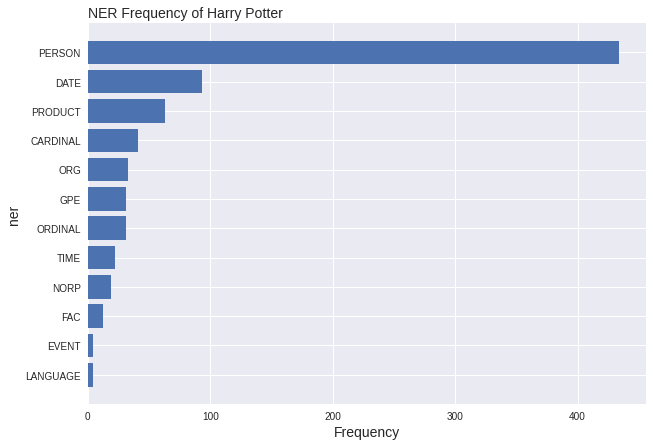

In [86]:
ner = ner_count['ner']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(ner, count)
ax.invert_yaxis()
ax.set_title('NER Frequency of Harry Potter',loc ='left', size = 14)
ax.set_ylabel('ner', size = 14)
ax.set_xlabel('Frequency', size = 14)

### 涉及到的人名(PERSON)

Text(0.5, 0, 'Word Frequency')

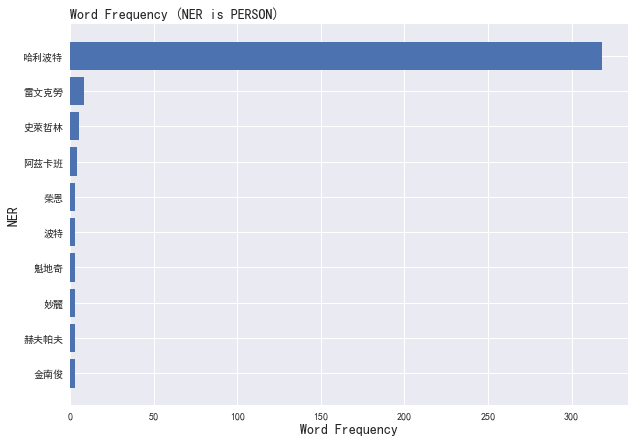

In [87]:
# 篩選ner為名詞的資料
l_noun = ["PERSON"]
PERSON = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前10個
ner_count = PERSON.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(10).reset_index()
ner_count

# 設定中文字形
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is PERSON)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)

看一下含特定關鍵字的貼文內容

In [88]:
keyword_list = ['雷文克勞','史萊哲林']
select = sentence_table[sentence_table['sentence'].str.contains('|'.join(keyword_list),regex=True)]
select.head(10)

,status_id,sentence
32,1439658050118316033,又測了兩次都是雷文克勞越了解哈利波特世界就越不獾院了餒，怎麼會這樣還是是我變了
129,1439535684394520578,好ㄌ啦雷文克勞真難相處
180,1439461184730763264,結論是🦈🔍赫夫帕夫🐙雷文克勞🐔💀葛來分多
476,1438840222100324352,問下，哈利波特應該去雷文克勞還是葛萊芬多，當然也考慮赫夫帕夫
624,1438558623370649606,邊工作邊想我要去哪個學院才好呢雷文克勞很棒但代表動物卻是老鷹💔
750,1438385633148297216,比較想加入雷文克勞或赫夫帕夫
751,1438385633148297216,剛剛別的單位的同事跑來跟我們單位的同事交流一下哈利波特，我順便問了他是哪個學院的，他說他是雷文克勞
752,1438385633148297216,他選雷文克勞的理由衣服好看
772,1438360019246874630,如果有朋朋玩哈利波特手遊的話，我是史萊哲林的，請當我的室友好嗎
877,1438125842983370756,哈利波特游戲裡在史萊哲林的休息室有一枚舊舊的徽章上面寫著波特臭大糞


大部分為角色名稱，「哈利波特」是主角也是遊戲名，被提及的次數最多，其次「榮恩」和「妙麗」被提及的頻率差不多；學院部分「雷文克勞」是許多人考慮熱門選項，且用戶普遍對「史萊哲林」的學院設定感興趣；另外遊戲中「阿茲卡班」的懲罰機制也是用戶討論重點。

### 涉及到的組織(ORG)

Text(0.5, 0, 'Word Frequency')

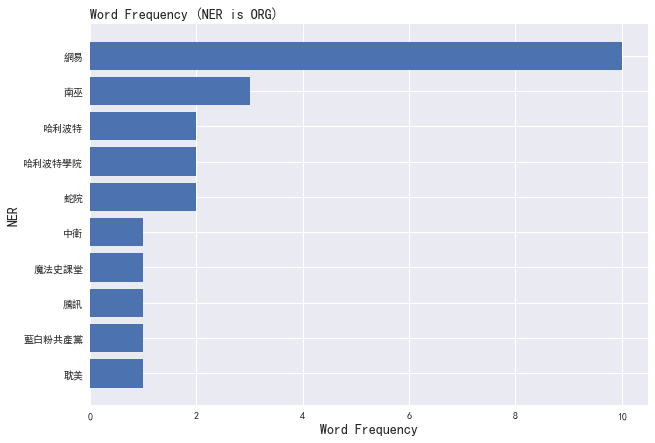

In [89]:
# 篩選ner為名詞的資料
l_noun = ["ORG"]
ORG = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前10個
ner_count = ORG.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(10).reset_index()
ner_count

# 設定中文字形
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is ORG)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)

部分網友因此款遊戲為「網易」出品而對遊戲的隱私性產生疑慮。

### 涉及到的民族、宗教、政治團體(NORP)

Text(0.5, 0, 'Word Frequency')

/usr/local/anaconda3/envs/test/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 12640 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/anaconda3/envs/test/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 12640 missing from current font.
  font.set_text(s, 0, flags=flags)


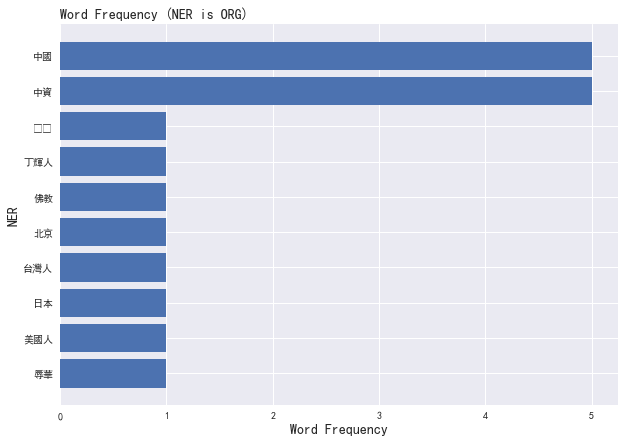

In [90]:
# 篩選ner為名詞的資料
l_noun = ["NORP"]
NORP = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前10個
ner_count = NORP.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(10).reset_index()
ner_count

# 設定中文字形
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is ORG)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)

In [91]:
keyword_list = ['中國','中資','北京']
sentence_table[sentence_table['sentence'].str.contains('|'.join(keyword_list),regex=True)]

,status_id,sentence
89,1439590611259064321,北京终于有哈利波特城堡啦///
232,1439282239364235267,雖然是中國的遊戲公司😢
252,1439268487797477377,不也是中資遊戲嗎
534,1438771788767383552,它是中國代理的哦
619,1438561043337265153,不管玩網易還是米哈游的中國遊戲，都不好意思跟身邊的人說，不過我個人倒不會對與中國來往有多麼大...
799,1438308622107230208,👾中國哈利波特手遊不能取台灣，網友出招反制
821,1438207911558221824,北京环球影城北京环球哈利波特///复制此链接，打开音搜索，直接观看视频
870,1438131770193371151,👾中國哈利波特手遊不能取台灣，網友出招反制
896,1438113445312827393,只可惜是中國做的就是了
927,1438078062386548739,👾中國哈利波特手遊不能取台灣，網友出招反制


承接ORG觀察到的高頻字詞，部分網友因魔法覺醒為中資而拒絕下載，也擔憂「中共」當局未來會將強審查力道，因「香港人」目前也列為敏感詞。

## 探索分析 - NER
有些較特別的詞在NER中可能沒有被標記到，來看看有沒有新發現

### POS 種類分析

查看辨識出哪幾種POS

In [92]:
pos_table['pos'].unique()

array(['FW', 'Nb', 'COMMACATEGORY', 'Na', 'VA', 'T', 'Nh', 'P', 'VE',
       'Nd', 'Nc', 'D', 'VK', 'I', 'Ng', 'VJ', 'VH', 'DE', 'Cbb', 'Neu',
       'V_2', 'VL', 'Nep', 'Nf', 'VCL', 'VG', 'VC', 'Di', 'Dfa', 'Neqa',
       'SHI', 'VHC', 'Ncd', 'Dk', 'Nes', 'A', 'Caa', 'VF', 'Dfb', 'Neqb',
       'Da', 'Cab', 'VD', 'VI', 'PERIODCATEGORY', 'DM',
       'PARENTHESISCATEGORY', 'Nv', 'VB', 'Cba', 'COLONCATEGORY', 'VAC'],
      dtype=object)

看看除了標點符號，大部分的POS都是哪一類

In [143]:
pos_filter = pos_table[~pos_table.pos.isin(['COMMACATEGORY', 'PARENTHESISCATEGORY', 'PERIODCATEGORY', 'COLONCATEGORY'])]

pos_count = pos_filter.groupby(['pos'])['pos'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False) \
                             .head(12)
pos_count

,pos,count
15,Na,2403
5,D,1607
13,FW,1147
35,VC,1145
16,Nb,1096
41,VH,895
27,Nh,713
6,DE,702
29,P,451
32,VA,374


Text(0.5, 0, 'Frequency')

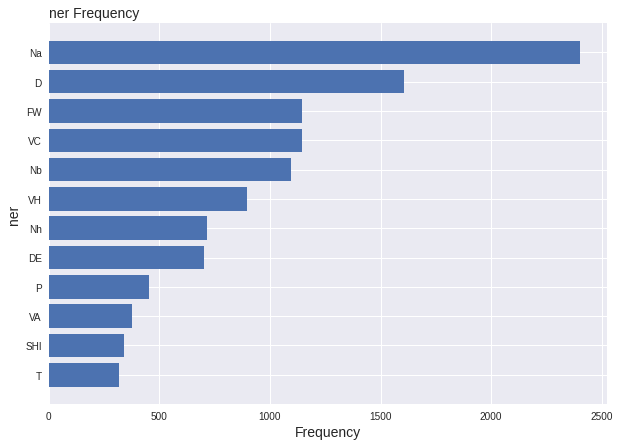

In [144]:
pos = pos_count['pos']
count = pos_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(pos, count)
ax.invert_yaxis()
ax.set_title('ner Frequency',loc ='left', size = 14)
ax.set_ylabel('ner', size = 14)
ax.set_xlabel('Frequency', size = 14)

#### POS 詞性列表: 
+ 中研院列表: https://ckip.iis.sinica.edu.tw/service/corenlp/
    + Na: 普通名詞
    + D: 副詞
    + VC: 動作及物動詞
    + Nb: 專有名詞
    + FW: 外文
    + VH: 狀態不及物動詞
    + Nh: 代名詞
    + DE: 的之得地
    + P: 介詞
    + VA: 動作不及物動詞
    + T: 語助詞
    + SHI: 是

### 涉及到的名詞(Na)
+ 我們可以找出談論魔法覺醒時大部分討論到的專有名詞，探索大家的關注焦點。
+ 名詞可以分為「Na: 普通名詞」、「Nb: 專有名詞」等

In [95]:
# 篩選pos為名詞的資料
l_noun = ["Nb"] #,"Na"
noun = pos_table[pos_table.pos.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前13個
noun_count = noun.groupby('word')['word'].agg(['count'])
noun_count = noun_count.sort_values(['count'],ascending=False)['count'].nlargest(15).reset_index()
noun_count

,word,count
0,哈利波特,667
1,游戏,31
2,哈利,20
3,伏地魔,10
4,波特,10
5,霍格沃兹,9
6,雷文克勞,9
7,魔宠传奇,7
8,主题元,7
9,網易,7


In [96]:
# 另外一種寫法
noun_count = noun[['word']].groupby(['word'])['word'] \
                                         .count() \
                                         .reset_index(name='count') \
                                         .sort_values(['count'], ascending=False) \
                                         .head(15)
noun_count

,word,count
44,哈利波特,667
142,游戏,31
43,哈利,20
18,伏地魔,10
138,波特,10
233,霍格沃兹,9
231,雷文克勞,9
243,魔宠传奇,7
7,主题元,7
177,網易,7


Text(0.5, 0, 'Word Frequency')

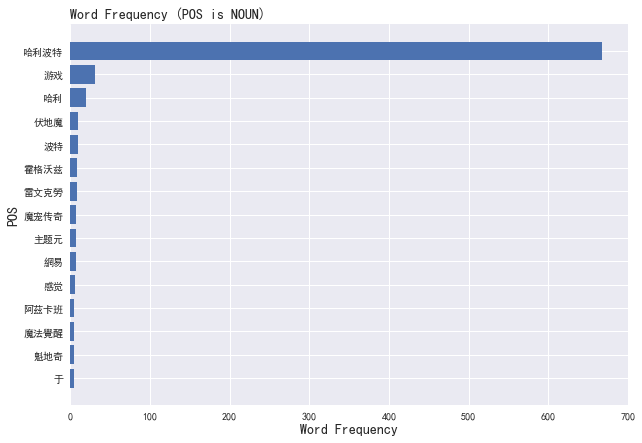

In [97]:


# 設定中文字形
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = noun_count['word']
count = noun_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (POS is NOUN)',loc ='left', size = 14)
ax.set_ylabel('POS', size = 14)
ax.set_xlabel('Word Frequency', size = 14)

可以看到魔法覺醒中，「伏地魔」也是討論度較高的角色，學院部分呼應上斷結論，「史萊哲林」和「雷文克勞」較熱門。

### 涉及到的動詞(VERB)
+ 我們可以找出談論魔法覺醒時大部分討論到的動詞，探索提到遊戲時的相關行為。
+ VC: 動作及物動詞、VH: 狀態不及物動詞、VA: 動作不及物動詞

In [98]:
l_verb = ["VH"] # ,"VH","VA"
verb = pos_table[pos_table.pos.isin(l_verb)] # 選取特定詞性
verb = verb[verb['word'].map(len) > 1] # 把長度為1的字去除掉

verb_count = verb[['word']].groupby(['word'])['word'] \
                                 .count() \
                                 .reset_index(name='count') \
                                 .sort_values(['count'], ascending=False) \
                                 .head(15)
verb_count

,word,count
94,好玩,24
348,魔法覺醒,22
239,直接,14
95,好看,12
288,觉醒,9
325,這樣,9
62,可愛,8
92,好好玩,7
61,可惜,7
20,不錯,7


Text(0.5, 0, 'Word Frequency')

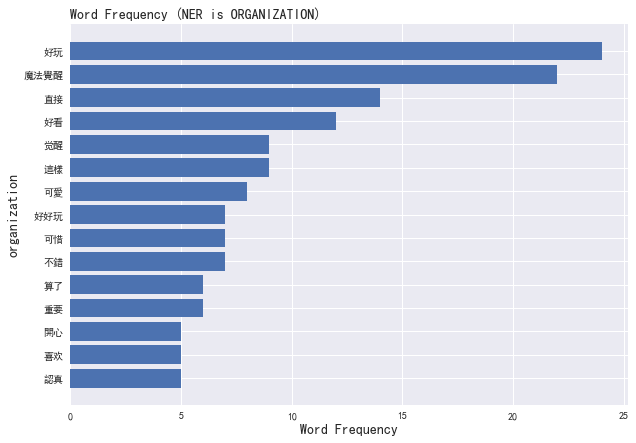

In [99]:
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = verb_count['word']
count = verb_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is ORGANIZATION)',loc ='left', size = 14)
ax.set_ylabel('organization', size = 14)
ax.set_xlabel('Word Frequency', size = 14)

發現在貼文中的動詞，「好玩」佔了相當高的頻率，其他還有出現「好好玩」、「喜歡」等詞彙，可推測玩家對此款遊戲滿意度高。

In [100]:
# 看一下含特定關鍵字的貼文內容
keyword_list = ['好玩','好看','好好玩']
select = sentence_table[sentence_table['sentence'].str.contains('|'.join(keyword_list),regex=True)]
select.head(5)

,status_id,sentence
47,1439641122402304000,哈利波特手遊好好玩
114,1439551486132850691,哈利波特的中国风皮肤，这个白旗袍挺好看////
115,1439550831800434688,哈利波特好好玩我一直在打決鬥社
138,1439520111770046466,哈利波特我覺得最好看ㄉ地方是從阿茲卡班的逃犯結尾那邊開始時間回溯一直到後面
195,1439433415149772802,蛤，我覺得哈利波特還蠻好玩的，怎麼辦


## 情緒分析

#### SnowNLP 
+ SnowNLP 針對中文設計，可以提取句子的情緒分類
+ 情緒值在 0~1之間，代表負面到正面
+ 官方github: https://github.com/isnowfy/snownlp

In [101]:
from snownlp import SnowNLP
s = SnowNLP('應該要開一個伺服器叫阿茲卡班')
s.sentiments # 範圍在 0~ 1之間 (負面~正面)

0.03430448367397765

將句子和日期合併，方便之後做分析

In [102]:
# sentence_table = pd.read_csv("source/zh/sentence_table_HarryPotter.csv") #匯資料
sentiment_date = pd.merge(sentence_table,tweets_df[['status_id','created_at','source']],on='status_id',how='left')
sentiment_date.head(3)

,status_id,sentence,created_at,source
0,1439738694584311810,_哈利波特，雙人組隊啊😂,2021-09-19 23:50:28,Twitter for iPhone
1,1439738139346567170,我跟我媽說湯姆跟艾瑪以前在哈利波特片場互相喜歡⋯,2021-09-19 23:48:16,Twitter for Android
2,1439738139346567170,欸你知道馬份跟妙麗戲外暗戀對方嗎,2021-09-19 23:48:16,Twitter for Android


In [103]:
def get_sentiment(sent):
    s = SnowNLP(sent)
    return s.sentiments

# 幫每句話加上情緒分數
sentiment_date['sentimentValue'] = sentiment_date.apply(lambda row : get_sentiment(row['sentence'],), axis = 1)
sentiment_date.head(5)

,status_id,sentence,created_at,source,sentimentValue
0,1439738694584311810,_哈利波特，雙人組隊啊😂,2021-09-19 23:50:28,Twitter for iPhone,0.997635
1,1439738139346567170,我跟我媽說湯姆跟艾瑪以前在哈利波特片場互相喜歡⋯,2021-09-19 23:48:16,Twitter for Android,0.986648
2,1439738139346567170,欸你知道馬份跟妙麗戲外暗戀對方嗎,2021-09-19 23:48:16,Twitter for Android,0.140883
3,1439738139346567170,👩‍👧真的假的我不知道欸,2021-09-19 23:48:16,Twitter for Android,0.303064
4,1439738139346567170,可是他們沒有在一起,2021-09-19 23:48:16,Twitter for Android,0.462185


In [104]:
# 看一下情緒的分布
sentiment_date['sentimentValue'].describe() # 2145句話

count    1522.000000
mean        0.702010
std         0.338112
min         0.000050
25%         0.446713
50%         0.885600
75%         0.995742
max         1.000000
Name: sentimentValue, dtype: float64

<AxesSubplot:>

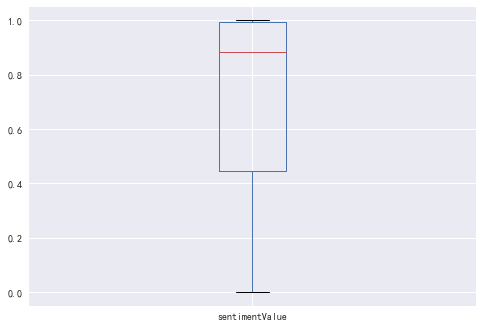

In [105]:
# 情緒分布的盒狀圖
boxplot = sentiment_date.boxplot(column=['sentimentValue'], showfliers=False)
boxplot

將每天的情緒分數取平均，並轉換時間格式為天

In [106]:
sentiment_date['created_at'] =  pd.to_datetime(sentiment_date['created_at']).dt.date
sentiment_count = sentiment_date.groupby(['created_at'])['sentimentValue'].mean().reset_index()
sentiment_count

,created_at,sentimentValue
0,2021-09-13,0.658437
1,2021-09-14,0.690771
2,2021-09-15,0.718597
3,2021-09-16,0.734480
4,2021-09-17,0.709320
5,2021-09-18,0.719035
6,2021-09-19,0.689233


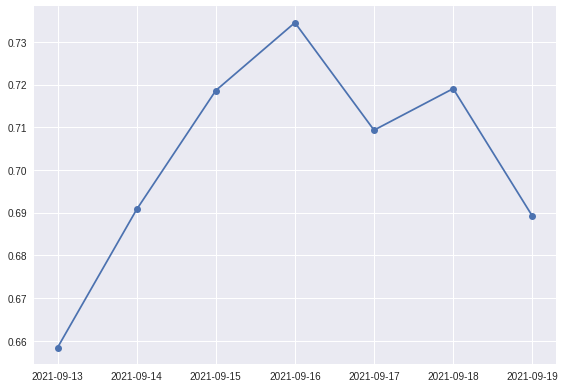

In [107]:
# 平均情緒分數時間趨勢
plt.style.use('seaborn')

dates = sentiment_count['created_at']
y = sentiment_count['sentimentValue']

plt.plot_date(dates, y, linestyle='solid')
plt.gcf().autofmt_xdate
plt.tight_layout()

plt.show()

## 不同用戶端情緒時間趨勢

In [108]:
# 篩出安卓和蘋果的用戶
sentiment_date = sentiment_date[sentiment_date['source'].isin(['Twitter for Android', 'Twitter for iPad'])]
# 算每天的情緒
source_count = sentiment_date.groupby(['created_at','source'])['sentimentValue'].mean().reset_index()
source_count

,created_at,source,sentimentValue
0,2021-09-13,Twitter for Android,0.564699
1,2021-09-13,Twitter for iPad,0.706528
2,2021-09-14,Twitter for Android,0.668570
3,2021-09-14,Twitter for iPad,0.576445
4,2021-09-15,Twitter for Android,0.702210
5,2021-09-15,Twitter for iPad,0.680091
6,2021-09-16,Twitter for Android,0.738287
7,2021-09-16,Twitter for iPad,0.732194
8,2021-09-17,Twitter for Android,0.688281
9,2021-09-17,Twitter for iPad,0.762021


In [109]:
# spread the column
source_pivot = source_count.pivot_table(index=['created_at'],columns='source',values='sentimentValue',fill_value=0).reset_index()
source_pivot

source,created_at,Twitter for Android,Twitter for iPad
0,2021-09-13,0.564699,0.706528
1,2021-09-14,0.668570,0.576445
2,2021-09-15,0.702210,0.680091
3,2021-09-16,0.738287,0.732194
4,2021-09-17,0.688281,0.762021
5,2021-09-18,0.698086,0.000000
6,2021-09-19,0.650384,0.661517


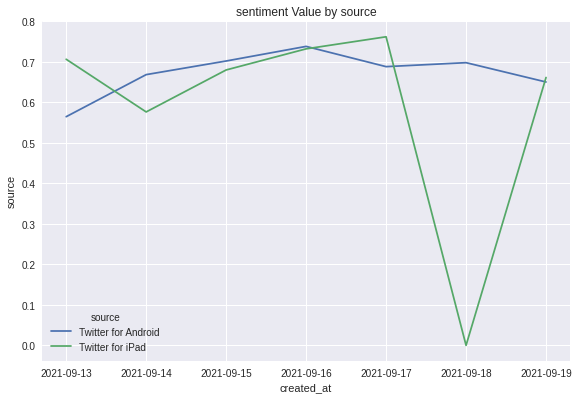

In [110]:
# 不同裝置情緒分數時間趨勢
plt.style.use('seaborn')

source_pivot.plot(x="created_at", y=["Twitter for Android", "Twitter for iPad"])
plt.gcf().autofmt_xdate
plt.tight_layout()

plt.ylabel('sentiment Value')
plt.ylabel('source')
plt.title('sentiment Value by source')

plt.show()

從上圖中發現大部分天數的情緒值都在0.5以上，偏向正面。只是9/15和9/16號的分數特別高，可以特別挑出來分析。

### 正面詞彙探索
從上圖中可以發現 9/15 和 9/17 的情緒特別高，我們把那兩天的正面句子挑出來看看他們都用甚麼詞，根據上面的盒狀圖我們可以發現，文中句子的情緒值大部分偏高，平均大概在0.8左右，臨界點取高一點，選情緒值選0.6以上的句子。

In [111]:
# 篩時間區間
startdate = pd.to_datetime("2021-09-15").date()
enddate = pd.to_datetime("2021-09-17").date()
filter_sentiment = sentiment_date[sentiment_date.created_at.between(startdate, enddate)]
filter_sentiment = filter_sentiment.loc[filter_sentiment['sentimentValue'] >= 0.6]

# 看一下正面句子都在討論甚麼
filter_sentiment

,status_id,sentence,created_at,source,sentimentValue
382,1438962753633456131,玩哈利波特后，今天是我睡得最早的一天,2021-09-17,Twitter for iPad,0.984097
402,1438930848062050306,收个哈利波特奴帮我打宝箱我老想不起来呜呜呜呜箱子都浪费了学年任务也没做社团活动也没做其实是想找老婆,2021-09-17,Twitter for Android,0.909156
403,1438920047523610631,哈利波特西弗勒斯·沈腾·斯内普,2021-09-17,Twitter for Android,0.999975
404,1438919777821642752,最近沉迷哈利波特,2021-09-17,Twitter for Android,0.996103
405,1438919777821642752,无心拍色图,2021-09-17,Twitter for Android,0.798607
...,...,...,...,...,...
1023,1437961668709924864,哈利波特吗,2021-09-15,Twitter for Android,0.994999
1027,1437949068362194944,吃完宵來一場哈利波特///,2021-09-15,Twitter for Android,0.987158
1028,1437939420338933760,來啦一起肝哈利波特坑,2021-09-15,Twitter for Android,0.989400
1029,1437939420338933760,香的,2021-09-15,Twitter for Android,0.649485


In [112]:
# 把時間分數和之前斷詞的token table做 join
positive_words = pd.merge(filter_sentiment,pos_table,on='status_id',how='left')
positive_words = positive_words[['status_id','sentimentValue','word']]
positive_words.head(5)

,status_id,sentimentValue,word
0,1438962753633456131,0.984097,玩
1,1438962753633456131,0.984097,哈利波特
2,1438962753633456131,0.984097,后
3,1438962753633456131,0.984097,，
4,1438962753633456131,0.984097,今天


In [130]:
# 篩選只有單個字元的結果
positive_words = positive_words[positive_words.apply(lambda x: len(x['word'])>1, axis=1)]

### 正面詞彙文字雲

In [124]:
# 自定停用字
with open('dict/stop_words.txt') as f:
    stop_words = f.read().splitlines()

print(stop_words)

[',', '?', '、', '。', '“', '”', '《', '》', '！', '，', '：', '；', '？', '再', '本來', '是不是', '一個', '這種', '人民', '末##末', '啊', '阿', '哎', '哎呀', '哎喲', '唉', '我', '我們', '按', '按照', '依照', '吧', '吧噠', '把', '罷了', '被', '本', '本著', '比', '比方', '比如', '鄙人', '彼', '彼此', '邊', '別', '別的', '別說', '並', '並且', '不比', '不成', '不單', '不但', '不獨', '不管', '不光', '不過', '不僅', '不拘', '不論', '不怕', '不然', '不如', '不特', '不惟', '不問', '不只', '朝', '朝著', '趁', '趁著', '乘', '沖', '除', '除此之外', '除非', '除了', '此', '此間', '此外', '從', '從而', '打', '待', '但', '但是', '當', '當著', '到', '得', '的', '的話', '等', '等等', '地', '第', '叮咚', '對', '對於', '多', '多少', '而', '而況', '而且', '而是', '而外', '而言', '而已', '爾後', '反過來', '反過來說', '反之', '非但', '非徒', '否則', '嘎', '嘎登', '該', '趕', '個', '各', '各個', '各位', '各種', '各自', '給', '根據', '跟', '故', '故此', '固然', '關於', '管', '歸', '果然', '果真', '過', '哈', '哈哈', '呵', '和', '何', '何處', '何況', '何時', '嘿', '哼', '哼唷', '呼哧', '乎', '嘩', '還是', '還有', '換句話說', '換言之', '或', '或是', '或者', '極了', '及', '及其', '及至', '即', '即便', '即或', '即令', '即若', '即使', '幾', '幾時', '己', '既', '既然', '既是', '繼而', '加之', 

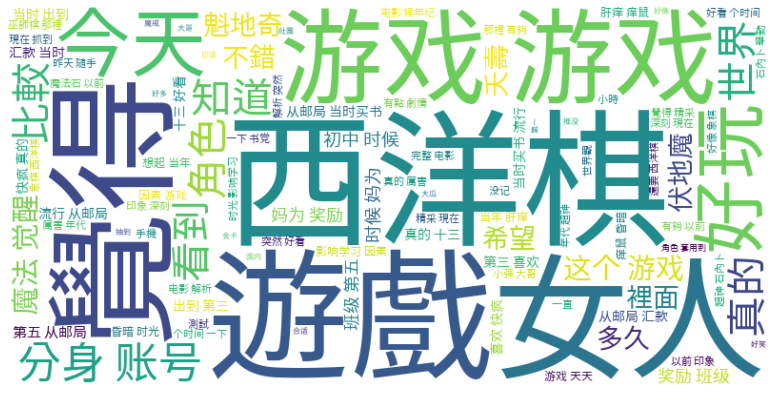

In [135]:


# 匯入自訂的 stop words (預設只有英文的)
stop_words_pos = stop_words
stop_words_pos.extend(('哈利波特','魔法覺醒','緩緩','綻放','最近'))
stop_words_pos = set(stop_words_pos)

# 設定中文字形
font_path = 'TaipeiSansTCBeta-Regular.ttf'

# 可以設定字型大小和背景顏色
wordcloud = WordCloud(
                stopwords=stop_words_pos,font_path=font_path,width=800, height = 400, max_words=100, background_color="white")

wordcloud.generate(' '.join(positive_words['word']))
# Display the generated image:
plt.figure(figsize = (14,7))
plt.imshow(wordcloud, interpolation="bilinear")

plt.axis("off")
plt.show()

在正面情緒的句子中，「西洋棋」關卡討論度高，也有部分貼文是在討論遊戲中的「角色」設定，也出現比較直接的情緒字「喜歡」、「好看」，或是蒐集遊戲中的「獎勵」等等。

### 負面詞彙探索
從上圖中可以發現 9/13,9/14 的情緒特別低，我們把那天的負面句子挑出來看看他們都用甚麼詞，根據上面的盒狀圖，我們選取情緒值小於0.5的句子。

In [136]:
# 篩時間區間
# sentiment_date.loc[sentiment_date.to_datetime(['2021-09-17', '2010-01-04'])]

date1 = pd.to_datetime('2021-09-13').date()
date2 = pd.to_datetime("2021-09-14").date()
filter_sentiment = sentiment_date[sentiment_date.created_at.isin([date1,date2])]
filter_sentiment = filter_sentiment.loc[filter_sentiment['sentimentValue'] < 0.5]

# 看一下負面句子都在討論甚麼
filter_sentiment.head(50)

,status_id,sentence,created_at,source,sentimentValue
1037,1437898667361333248,但該打的手槍還是要打的咦,2021-09-14,Twitter for Android,0.431861
1038,1437898667361333248,///,2021-09-14,Twitter for Android,0.250000
1041,1437870373761019904,我以為我們這個年紀的童年至少也會聽過如果是現在的小朋友倒是有可能🥺,2021-09-14,Twitter for Android,0.296481
1044,1437853092645523457,雖然這個遊戲拿到很好的，,2021-09-14,Twitter for Android,0.146217
1046,1437853092645523457,但是在這自由的島嶼上，,2021-09-14,Twitter for Android,0.453672
1049,1437853092645523457,台灣人生長在自由的島嶼,2021-09-14,Twitter for Android,0.238839
1050,1437853092645523457,///,2021-09-14,Twitter for Android,0.250000
1052,1437847303545520128,///,2021-09-14,Twitter for Android,0.250000
1054,1437846069979672576,唐可可///,2021-09-14,Twitter for Android,0.403145
1061,1437840505077854210,我接着问他什么星座，他说他双鱼座,2021-09-14,Twitter for Android,0.053594


In [139]:
# 把時間分數和之前斷詞的token table做 join
negative_words = pd.merge(filter_sentiment,pos_table,on='status_id',how='left')
negative_words = negative_words[['status_id','sentimentValue','word']]

In [141]:
# 篩選只有單個字元的結果
negative_words = negative_words[negative_words.apply(lambda x: len(x['word'])>1, axis=1)]

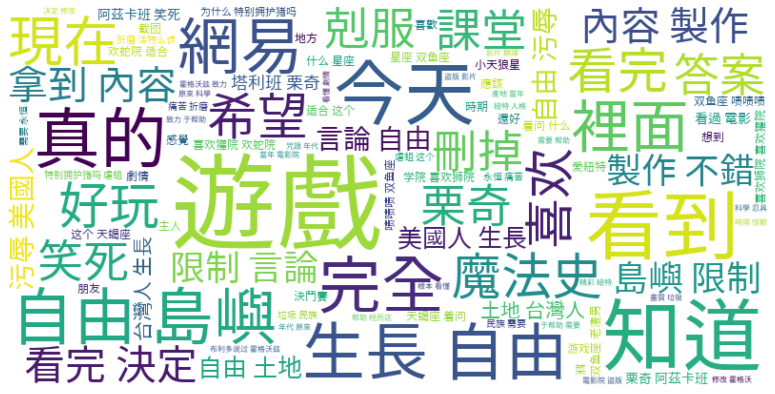

In [142]:

# 匯入自訂的 stop words (預設只有英文的)
stop_words_neg = stop_words
stop_words_neg.extend(('哈利波特','魔法覺醒','覺醒','玩'))
stop_words_neg = set(stop_words_neg)


# 設定中文字形
font_path = 'TaipeiSansTCBeta-Regular.ttf'

# 可以設定字型大小和背景顏色
wordcloud = WordCloud(
                stopwords=stop_words_neg,font_path=font_path,width=800, height = 400, max_words=100, background_color="white")\
                .generate(' '.join(negative_words['word']))

# Display the generated image:
plt.figure(figsize = (14,7))
plt.imshow(wordcloud, interpolation="bilinear")

plt.axis("off")
plt.show()

負面情緒多因此款遊戲為「中資」、「網易」主導而拒玩的相關討論貼文，也出現「限制」、「言論」，「台灣人」在自由島嶼等相關文字，另外也有網友不滿「刪掉」遊戲。

### 相關 code 參考
+ 相關文件
    + coreNLP
        + CoreNLPClient parameter
        + https://stanfordnlp.github.io/stanza/client_properties.html
    + tweetpy
        + API.search
        + https://docs.tweepy.org/en/v3.5.0/api.html#help-methods
        + API.search input output
        + https://developer.twitter.com/en/docs/twitter-api/v1/tweets/search/api-reference/get-search-tweets
        + search query rule
        + https://developer.twitter.com/en/docs/twitter-api/tweets/search/integrate/build-a-query
        + lang 抓取語言列表
        + https://developer.twitter.com/en/docs/twitter-for-websites/supported-languages
+ 參考code
    + 抓取twitter table
    + https://amandeepsaluja.com/getting-twitter-keyword-data-in-table-format-using-python/